In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sksurv.metrics import concordance_index_censored
import numpy as np
import scipy.stats
from functools import partial
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

In [765]:
import sys
from pathlib import Path
from joblib import Parallel, delayed
import json

Configure plot style

In [766]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

Declarations and definitions

In [767]:
def mean_confidence_interval(data, confidence=0.95):
    """Calculate mean, and lower and upper bound of confidence interval"""
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [768]:
def Dxy(event_observed, cve_lifetime, predicted_scores):
    """Calculate Dxy

    Rescale values from 0<=x<=1 range, where 0 is perfect anti-concordance,
    and 0.5 is the expected result from random predictions,
    to the -1<=x<=1 range
    """
    #return 2 * concordance_index_censored(event_observed, cve_lifetime, predicted_scores)[0] - 1
    return 2 * concordance_index(cve_lifetime, predicted_scores, event_observed) - 1

In [769]:
def bootstrap_dxy_inner(df):
    """Bootstrapped Dxy calculation, randomly sampled with replacement

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe to sample to compute Dxy from concordance index.
        Assumes that first 3 columns in this dataframe are:

        1. boolean column denoting which events were observed (un-censored)
        2. column with event times, in this case CVE lifetime (time to fix)
        3. column with predicted score, assumed to be category number,
           ordered in such way that larger values predict shorter lifetime

        Other columns are not used.

    Returns
    -------
    float
        Coefficient of concordance correlation, a number between –1 and 1 that
        measures the strength and direction of the relationship between
        predicted score (risk factor) and event time (CVE survival lifetime).
    """
    e, y, x = df.columns
    sample = df.sample(n=df.shape[0], replace=True)

    # calculate Dxy from sample
    return Dxy(sample[e], sample[y], sample[x])


def bootstrap_dxy(df, n=5):
    """Boostrap and calculate Dxy, resampling `n` times"""
    # resample n times
    result = Parallel(n_jobs=-1)(delayed(bootstrap_dxy_inner)(df) for _ in range(n))

    return result

In [770]:
def apply_stats_for_each_value(params, df, fmap, condition_names=None, df_mask=None):
    """Apply stats to each value in column"""

    all_count = df.shape[0]

    if df_mask is not None:
        df = df[df_mask]

    dff = pd.DataFrame({'E': df['E'], 'Y': df['Y'], 'agg': df.apply(fmap, axis=1)}).dropna()
    selected_count = dff.shape[0]
    print(f"all = {all_count}, selected = {selected_count}, uncensored = {dff['E'].sum()}",
               file=sys.stderr)

    # DEBUG
    #print(dff.head())

    stats = dff['Y'].aggregate(['count', 'median'])

    print(f"Computing {params['bootstrap_samples']} × bootstrap Dxy " +
          f"for {dff.shape[0]} elements...", file=sys.stderr)
    dxy_bootstrapped = bootstrap_dxy(dff[['E', 'Y', 'agg']], params['bootstrap_samples'])
    # DEBUG
    #print(dxy_bootstrapped)
    # confidence interval
    print(f"Computing confidence interval from {len(dxy_bootstrapped)} samples...", file=sys.stderr)
    dxy, ci_low, ci_high = mean_confidence_interval(dxy_bootstrapped, confidence=params['confidence'])

    ret = {
        'Cohort': all_count,
        'Number of patients': stats['count'],
        '% of cohort': 100.0*selected_count / all_count,
        'Survival days, median': stats['median'],
        'Survival years, median': stats['median'] / 365,
        'Dxy (full)': Dxy(dff['E'], dff['Y'], dff['agg']),
        'bootstrap': {
            'Dxy': dxy,
            'Confidence interval low': ci_low,
            'Confidence interval high': ci_high,
            'confidence threshold %': 100.0*params['confidence'],
            'bootstrap samples': params['bootstrap_samples'],
        },
    }

    print("Computing descriptive statistics like mean, median, etc....", file=sys.stderr)
    dff_groupby_y = dff.groupby(by=['agg'])['Y']
    groups = dff_groupby_y\
        .agg(['count', 'median', 'min',
              lambda x: np.percentile(x, q=25), lambda x: np.percentile(x, q=75),
              'max', 'mean', 'std', 'skew'])\
        .rename(columns={'<lambda_0>': '25%', '<lambda_1>': '75%'})
    groups['% of cohort'] = 100.0*groups['count']/all_count
    groups['% of selected'] = 100.0*groups['count']/selected_count
    groups['% of patients'] = 100.0*groups['count']/stats['count']
    groups['IR'] = groups['75%'] - groups['25%']

    # DEBUG
    #print(dff_groupby_y.describe())

    groups.index.names = [ params['risk_column_name'] ]
    if condition_names:
        groups.index = groups.index.map(condition_names)

    return ret, groups, dff

In [771]:
def plot_survival_function(params, dff, condition_names=None, plot_basename=None):
    """Create plot of survival function

    Parameters
    ----------
    params : dict
        Uses params['cve_survival_analysis']['risk_column_name'] and
        params['description'] to create plot titles
    dff : pandas.DataFrame
        The dataframe with data to compute survival function from
    condition_names : dict | None
        Mapping from risk factor score to risk factor name
    plot_basename : str | None
        Basename of where to save plots in SVG and PDF formats.
        If not set, derive basename from risk column name, if possible.
    """
    values_list = dff["agg"].unique()
    if condition_names is not None:
        values_list = condition_names.keys()
    print(f"values_list = {values_list}")
    for value in values_list:
        mask = (dff["agg"] == value)  # it's a boolean-valued pd.Series
        time_cell, survival_prob_cell = kaplan_meier_estimator(dff["E"][mask], dff["Y"][mask])
        plt.step(time_cell, survival_prob_cell, where="post",
                 label=f"{condition_names[value]} (n = {mask.sum():d}, median = {dff['Y'][mask].median():.0f})"
                       if condition_names else
                       f"{value:d} (n = {mask.sum():d}, median = {dff['Y'][mask].median():.0f})"
                 )

    if 'risk_column_name' in params:
        plt.suptitle(f"Risk factor: '{params['risk_column_name']}'")
    if 'description' in params:
        plt.title(params['description'])
    plt.ylabel("est. probability of survival $\\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    
    if plot_basename is None:
        if 'risk_column_name' in params and '/' not in params['risk_column_name']:
            plot_basename = params['risk_column_name']
    
    if plot_basename is not None:
        plt.savefig(f"{plot_basename}.svg")
        plt.savefig(f"{plot_basename}.pdf")
        print(f"Saved survival function plot to '{plot_basename}.svg' and *.pdf", file=sys.stderr)
        
    plt.show()
    #plt.clf()

In [772]:
def create_values_ranking_list(column_s, column_dtype):
    # if column_dtype is ordered category, we can use the order;
    # or column_dtype is unordered category with two values, any order is good;
    # or column_dtype is some kind of integer, we can use values

    # or column_dtype == 'category'
    if isinstance(column_dtype, pd.CategoricalDtype):
        if column_dtype.ordered:
            # we can use category ordering as ranking
            return column_dtype.categories.to_list()
        if column_dtype.categories.shape[0] == 2:
            # any order is good, we can get correlation or anti-correlation
            return column_dtype.categories.to_list()

    if pd.api.types.is_string_dtype(column_dtype) \
            and column_s.nunique(dropna=True) == 2:
        return column_s.unique().tolist()

    # we can't create ranking list of values
    return None

In [773]:
def values_ranking_hashes(values_ranking_list):
    values_ranking_hash = { value: idx
                            for (idx, value) in enumerate(values_ranking_list) }
    rankings_condition_names = { idx: value
                                 for (idx, value) in enumerate(values_ranking_list) }

    return values_ranking_hash, rankings_condition_names

In [774]:
def f_map_int(row, column_name, min_value=None, max_value=None):
    value = int(row[column_name])
    if min_value is not None and value < min_value:
        return None
    if max_value is not None and value > max_value:
        return None

    return value


def f_map_bool(row, column_name):
    value = bool(row[column_name])
    return value


def f_map_generic(row, column_name, values_ranking_hash):
    value = row[column_name]
    if value in values_ranking_hash:
        return values_ranking_hash[value]

    return None

In [775]:
def uniquify(param):
    seen = set()
    uniq = []
    for elem in param:
        if elem not in seen:
            uniq.append(elem)
            seen.add(elem)

    return uniq

In [776]:
def read_df(input_df):
    print(f"Reading input dataframe from '{input_df}'...")
    df = pd.read_parquet(input_df)
    print(f"{df.shape[0]} elems")
    df = df.drop_duplicates()
    print(f"{df.shape[0]} width duplicates dropped")
    return df

## Read data

In [1011]:
DATA_PREFIX="~jnareb/echoes_of_vulnerabilities_code/data/"

In [1012]:
#df = read_df(DATA_PREFIX + "cve_survival_input_df")
df = read_df(DATA_PREFIX + "cve_survival_input_most_used_language_df")

Reading input dataframe from '~jnareb/echoes_of_vulnerabilities_code/data/cve_survival_input_most_used_language_df'...
97747 elems
97747 width duplicates dropped


In [1013]:
df.head()

commits    commit_cves                             project_names  \
0        1  CVE-2011-1079                        0-artnoc_sm-a307fn   
1        2  CVE-2011-1079             150balbes_Amlogic_s905-kernel   
2        1  CVE-2011-1079            84506232_sm-g9750_graingripper   
3        1  CVE-2011-1079                        Ante0_CarbonKernel   
4        2  CVE-2011-1079  Backup-Gits_Eureka-Kernel-Exynos7885-Q-R   

   used_dep_manager cve_lifespan_commiter_time cve_lifespan_author_time  \
0                 0         3497 days 01:37:41       2978 days 21:29:59   
1                 0         3069 days 09:26:00       2978 days 21:29:59   
2                 0         3098 days 12:25:02       2978 days 21:29:59   
3                 0         2958 days 16:10:21       2978 days 21:29:59   
4                 0         3751 days 10:01:38       2978 days 21:29:59   

   embargo_min  embargo_max  lang_Shell  other_languages  ...  \
0        False        False         0.0              0.0  ...   
1        False        False         0.0              0.0  ...   
2        False        False         0.0              0.0  ...   
3        False        False         0.0              0.0  ...   
4        False        False         0.0              0.0  ...   

           LatestCommitDate  NumActiveMon  NumAuthors NumCore  CommunitySize  \
0 2020-10-30 00:34:41+00:00            66        1621     655              2   
1 2021-07-05 09:53:03+00:00            54        2498     776             60   
2 2019-11-13 00:24:16+00:00            37        1721     691              3   
3 2019-05-22 16:39:21+00:00            38        1277     536              1   
4 2021-07-11 12:23:58+00:00            75        1946     723              1   

  NumCommits  NumBlobs NumFiles  NumForks NumStars  
0       5233     64451    59744         1     <NA>  
1      17607    433579   136904        93      123  
2       5964     72923    65607         2        1  
3       3940     66416    61845         0     <NA>  
4      13242     68725    61715         0     <NA>  

[5 rows x 46 columns]

In [1014]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97747 entries, 0 to 97746
Data columns (total 46 columns):
 #   Column                                Non-Null Count  Dtype              
---  ------                                --------------  -----              
 0   commits                               97747 non-null  int64              
 1   commit_cves                           97747 non-null  object             
 2   project_names                         97747 non-null  object             
 3   used_dep_manager                      97747 non-null  int64              
 4   cve_lifespan_commiter_time            97747 non-null  timedelta64[ns]    
 5   cve_lifespan_author_time              97747 non-null  timedelta64[ns]    
 6   embargo_min                           97747 non-null  bool               
 7   embargo_max                           97747 non-null  bool               
 8   lang_Shell                            97747 non-null  float64            
 9   other_languages  

In [1015]:
True < False

False

In [1016]:
(df['embargo_min'] < df['embargo_max']).value_counts()

False    97747
dtype: int64

Project metadata columns to analyze
- [x] CommitDateRange \[days] = (LatestCommitDate - EarliestCommitDate).dt.days
- [x] NumActiveMon
    - [x] NumActiveMon \[%]
- [x] NumAuthors
    - [x] NumCore / NumAuthors
- [x] NumCore
- [x] NumCommits
- [x] NumStars
- [x] NumForks
- [x] CommunitySize
- [x] NumFiles
- [x] NumBlobs

In [1017]:
df.describe()

commits  used_dep_manager    cve_lifespan_commiter_time  \
count  97747.000000      97747.000000                         97747   
mean       5.131370          0.091010   569 days 12:15:14.104136192   
std       29.965625          0.749142  1065 days 00:37:52.891798944   
min        1.000000          0.000000               0 days 00:00:00   
25%        1.000000          0.000000              17 days 20:54:23   
50%        1.000000          0.000000             142 days 11:27:36   
75%        3.000000          0.000000      565 days 06:42:21.500000   
max     2349.000000         51.000000            8019 days 14:41:17   

          cve_lifespan_author_time    lang_Shell  other_languages  \
count                        97747  97747.000000     97747.000000   
mean   508 days 01:10:43.362916504     27.577215       550.704410   
std    952 days 19:25:26.467939360    150.017086      3643.865682   
min                0 days 00:00:00      0.000000         0.000000   
25%               11 days 02:02:03      0.000000         0.000000   
50%               95 days 01:48:02      0.000000         0.000000   
75%              485 days 18:09:29      0.000000         2.000000   
max             8019 days 14:41:17  11867.000000    153573.000000   

       most_common_language_number_of_files  programming_paradigm  \
count                          97747.000000          97747.000000   
mean                             697.357351              1.178931   
std                             5962.393441              0.566677   
min                                1.000000              1.000000   
25%                                1.000000              1.000000   
50%                                2.000000              1.000000   
75%                               12.000000              1.000000   
max                           616542.000000              3.000000   

       compilation_class    type_class  ...          cvss  NumActiveMon  \
count       97747.000000  97747.000000  ...  97408.000000  97747.000000   
mean            1.489130      1.479646  ...      5.905945    131.199628   
std             0.499884      0.499588  ...      1.913505    111.975451   
min             1.000000      1.000000  ...      0.000000      1.000000   
25%             1.000000      1.000000  ...      4.600000     37.000000   
50%             1.000000      1.000000  ...      5.600000     98.000000   
75%             2.000000      2.000000  ...      7.500000    223.000000   
max             2.000000      2.000000  ...     10.000000    698.000000   

          NumAuthors       NumCore  CommunitySize    NumCommits      NumBlobs  \
count   96989.000000  96989.000000   97739.000000  9.754800e+04  9.774700e+04   
mean     5535.744486    265.390178    6350.670950  1.787815e+06  1.198616e+06   
std     21014.545084    768.812445   22808.681054  7.052023e+06  4.005463e+06   
min         1.000000      1.000000       1.000000  1.000000e+00  1.000000e+00   
25%        15.000000      3.000000       1.000000  3.620000e+02  3.842000e+03   
50%       203.000000     18.000000       6.000000  1.000300e+04  7.283400e+04   
75%      1721.000000    210.000000     643.000000  1.404250e+05  5.011510e+05   
max    109725.000000  16920.000000  154323.000000  3.646839e+07  3.604579e+07   

           NumFiles       NumForks       NumStars  
count  9.774700e+04   97739.000000   71125.000000  
mean   5.255018e+05   10991.043882   16564.959972  
std    1.695992e+06   45501.244094   49107.892685  
min    1.000000e+00       0.000000       1.000000  
25%    1.552000e+03       0.000000       4.000000  
50%    4.266600e+04       5.000000     119.000000  
75%    1.825950e+05     643.000000    2902.000000  
max    4.307279e+07  237104.000000  285958.000000  

[8 rows x 22 columns]

## Analyze

In [1018]:
df['E'] = True
df['Y']=df['cve_lifespan_commiter_time'].dt.days

In [1019]:
df[['Y','E']].describe()

Y
count  97747.000000
mean     569.044810
std     1065.012619
min        0.000000
25%       17.000000
50%      142.000000
75%      565.000000
max     8019.000000

Limit to lifetime $\le$ 365 days

In [1020]:
df_full=df
df=df[df['Y'] <= 365]
#df

In [1021]:
df[['Y','E']].describe()

Y
count  62866.000000
mean      79.680225
std       97.347788
min        0.000000
25%        6.000000
50%       34.000000
75%      124.000000
max      365.000000

In [1022]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62866 entries, 43 to 97745
Data columns (total 48 columns):
 #   Column                                Non-Null Count  Dtype              
---  ------                                --------------  -----              
 0   commits                               62866 non-null  int64              
 1   commit_cves                           62866 non-null  object             
 2   project_names                         62866 non-null  object             
 3   used_dep_manager                      62866 non-null  int64              
 4   cve_lifespan_commiter_time            62866 non-null  timedelta64[ns]    
 5   cve_lifespan_author_time              62866 non-null  timedelta64[ns]    
 6   embargo_min                           62866 non-null  bool               
 7   embargo_max                           62866 non-null  bool               
 8   lang_Shell                            62866 non-null  float64            
 9   other_languages 

In [1023]:
results_summary={}

### NumCore and NumAuthors

**NumCore**

<AxesSubplot: ylabel='Count'>

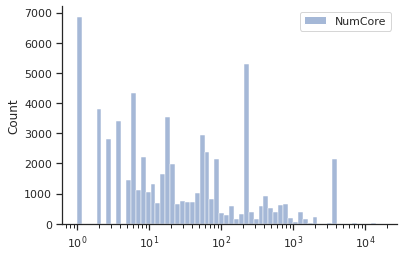

In [1024]:
sns.histplot(data=df[['NumCore']].dropna(),log_scale=True)

/tmp/ipykernel_3850516/1701945013.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NumCore_cut5'] = numcore_cut


NumCore_cut5
[1.0, 2.0)          6865
[2.0, 10.0)        19117
[10.0, 100.0)      22557
[100.0, 1000.0)    11240
[1000.0, inf)       3034
dtype: int64

CategoricalDtype(categories=[[1.0, 2.0), [2.0, 10.0), [10.0, 100.0), [100.0, 1000.0), [1000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumCore_cut5', ylabel='CVE+project'>

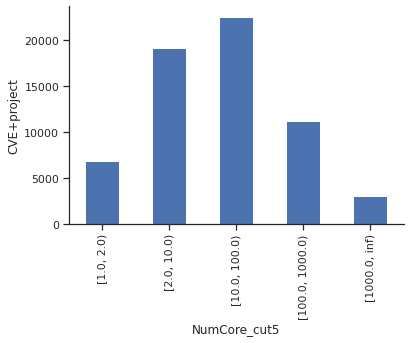

In [1025]:
numcore_cut = pd.cut(df['NumCore'].dropna(),
                     bins=[1,2,10,100,1000,np.inf],right=False,include_lowest=True)
df['NumCore_cut5'] = numcore_cut
display(df.value_counts('NumCore_cut5').sort_index())
display(numcore_cut.dtype)

df.value_counts('NumCore_cut5').sort_index().plot.bar(ylabel='CVE+project')

In [1026]:
column_name='NumCore'
column_cut='NumCore_cut5'
ranking_list = create_values_ranking_list(df['NumCore_cut5'], df['NumCore_cut5'].dtype)
ranking_list

[Interval(1.0, 2.0, closed='left'),
 Interval(2.0, 10.0, closed='left'),
 Interval(10.0, 100.0, closed='left'),
 Interval(100.0, 1000.0, closed='left'),
 Interval(1000.0, inf, closed='left')]

In [1027]:
(values_hash, values_names) = values_ranking_hashes(ranking_list)

In [1028]:
f_map = lambda row: f_map_generic(row, 'NumCore_cut5', values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': 'NumCore_cut5',
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

all = 62866, selected = 62813, uncensored = 62813
Computing 100 × bootstrap Dxy for 62813 elements...
Computing confidence interval from 100 samples...


{
    "Cohort": 62866,
    "Number of patients": 62813.0,
    "% of cohort": 99.91569369770623,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.12396463985078343,
    "bootstrap": {
        "Dxy": 0.12396794853253011,
        "Confidence interval low": 0.12351062411556941,
        "Confidence interval high": 0.12442527294949081,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


Computing descriptive statistics like mean, median, etc....


count  median  min   25%    75%  max        mean         std  \
NumCore_cut5                                                                    
[1.0, 2.0)        6865    31.0    0   6.0  111.0  365   75.480117   95.185137   
[2.0, 10.0)      19117    18.0    0   2.0   85.0  365   61.429356   88.111172   
[10.0, 100.0)    22557    30.0    0   5.0  105.0  365   70.990602   90.692834   
[100.0, 1000.0)  11240    92.0    0  25.0  209.0  365  123.118327  108.829373   
[1000.0, inf)     3034    69.0    0  18.0  183.0  365  108.087343  106.166542   

                     skew  % of cohort  % of selected  % of patients     IR  
NumCore_cut5                                                                 
[1.0, 2.0)       1.431111    10.920052      10.929266      10.929266  105.0  
[2.0, 10.0)      1.688703    30.409124      30.434783      30.434783   83.0  
[10.0, 100.0)    1.511993    35.881080      35.911356      35.911356  100.0  
[100.0, 1000.0)  0.608950    17.879299      17.894385      17.894385  184.0  
[1000.0, inf)    0.845891     4.826138       4.830210       4.830210  165.0

In [1029]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

values_list = dict_keys([0, 1, 2, 3, 4])


Saved survival function plot to 'NumCore_cut5.svg' and *.pdf


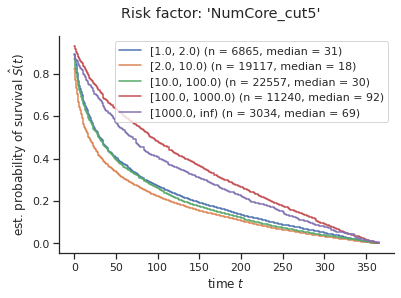

In [1030]:
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='Y', ylabel='NumCore_cut5'>

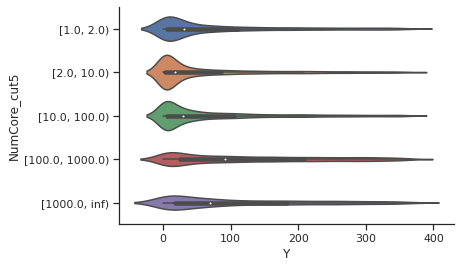

In [1031]:
sns.violinplot(data=df, x="Y", y="NumCore_cut5")

----

/tmp/ipykernel_3850516/2686907847.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NumCore_cut2'] = numcore_cut


NumCore_cut2
[10.0, inf)    36831
[1.0, 10.0)    25982
dtype: int64

CategoricalDtype(categories=[[1.0, 10.0), [10.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumCore_cut2', ylabel='CVE+project'>

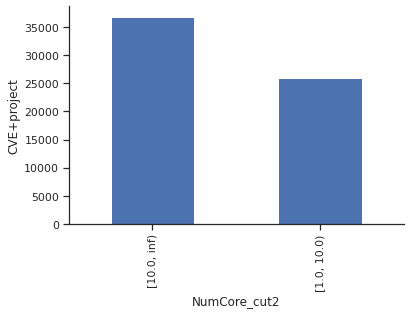

In [1032]:
column_name='NumCore'
column_cut='NumCore_cut2'
numcore_cut = pd.cut(df['NumCore'].dropna(),
                     bins=[1,10,np.inf],right=False,include_lowest=True)
df['NumCore_cut2'] = numcore_cut
display(df.value_counts('NumCore_cut2'))
display(numcore_cut.dtype)

df.value_counts('NumCore_cut2').plot.bar(ylabel='CVE+project')

In [1033]:
ranking_list = create_values_ranking_list(df['NumCore_cut2'], df['NumCore_cut2'].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

In [1034]:
f_map = lambda row: f_map_generic(row, 'NumCore_cut2', values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': 'NumCore_cut2',
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

all = 62866, selected = 62813, uncensored = 62813
Computing 100 × bootstrap Dxy for 62813 elements...


{
    "Cohort": 62866,
    "Number of patients": 62813.0,
    "% of cohort": 99.91569369770623,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.08600375912162272,
    "bootstrap": {
        "Dxy": 0.08586543332341272,
        "Confidence interval low": 0.08547618948963265,
        "Confidence interval high": 0.08625467715719279,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


Computing confidence interval from 100 samples...
Computing descriptive statistics like mean, median, etc....


count  median  min  25%    75%  max       mean         std  \
NumCore_cut2                                                               
[1.0, 10.0)   25982    21.0    0  3.0   92.0  365  65.141867   90.245350   
[10.0, inf)   36831    47.0    0  9.0  147.0  365  89.954712  100.811009   

                  skew  % of cohort  % of selected  % of patients     IR  
NumCore_cut2                                                              
[1.0, 10.0)   1.614717    41.329176      41.364049      41.364049   89.0  
[10.0, inf)   1.117080    58.586517      58.635951      58.635951  138.0

In [1035]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

values_list = dict_keys([0, 1])


Saved survival function plot to 'NumCore_cut2.svg' and *.pdf


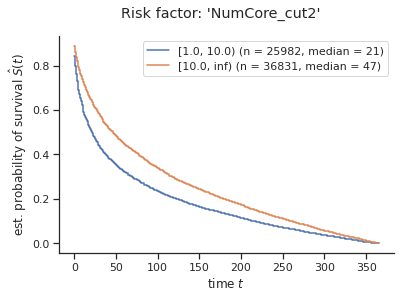

In [1036]:
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='Y', ylabel='NumCore_cut2'>

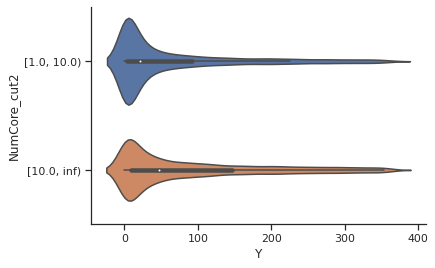

In [1037]:
sns.violinplot(data=df, x="Y", y="NumCore_cut2")

/tmp/ipykernel_3850516/2359287404.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = numcore_cut


NumCore_cut3
[1.0, 5.0)     16872
[5.0, 50.0)    23188
[50.0, inf)    22753
dtype: int64

CategoricalDtype(categories=[[1.0, 5.0), [5.0, 50.0), [50.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumCore_cut3', ylabel='CVE+project'>

[Interval(1.0, 5.0, closed='left'),
 Interval(5.0, 50.0, closed='left'),
 Interval(50.0, inf, closed='left')]

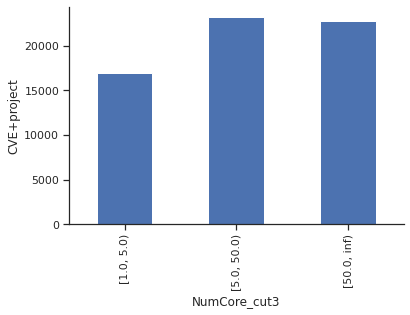

In [1038]:
column_name='NumCore'
column_cut='NumCore_cut3'

numcore_cut = pd.cut(df['NumCore'].dropna(),
                     bins=[1,5,50,np.inf],right=False,include_lowest=True)
df[column_cut] = numcore_cut
display(df.value_counts(column_cut).sort_index())
display(numcore_cut.dtype)


df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
ranking_list

In [1039]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

{0: Interval(1.0, 5.0, closed='left'),
 1: Interval(5.0, 50.0, closed='left'),
 2: Interval(50.0, inf, closed='left')}

all = 62866, selected = 62813, uncensored = 62813
Computing 100 × bootstrap Dxy for 62813 elements...


{
    "Cohort": 62866,
    "Number of patients": 62813.0,
    "% of cohort": 99.91569369770623,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.08751471522811793,
    "bootstrap": {
        "Dxy": 0.0872686971179294,
        "Confidence interval low": 0.08675501870813962,
        "Confidence interval high": 0.08778237552771917,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


Computing confidence interval from 100 samples...
Computing descriptive statistics like mean, median, etc....


count  median  min   25%    75%  max        mean         std  \
NumCore_cut3                                                                 
[1.0, 5.0)    16872    29.0    0   5.0  112.0  365   74.451577   95.174413   
[5.0, 50.0)   23188    20.0    0   3.0   87.0  365   61.843367   86.959993   
[50.0, inf)   22753    61.0    0  14.0  171.0  365  101.765350  104.440581   

                  skew  % of cohort  % of selected  % of patients     IR  
NumCore_cut3                                                              
[1.0, 5.0)    1.414561    26.838036      26.860682      26.860682  107.0  
[5.0, 50.0)   1.712811    36.884803      36.915925      36.915925   84.0  
[50.0, inf)   0.917871    36.192855      36.223393      36.223393  157.0

<AxesSubplot: xlabel='Y', ylabel='NumCore_cut3'>

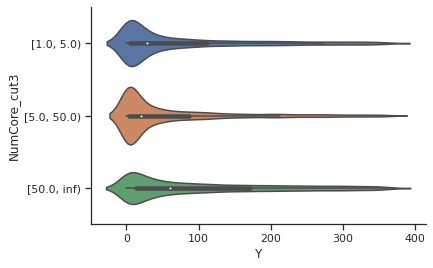

In [1040]:
sns.violinplot(data=df, x="Y", y=column_cut)

In [1041]:
print(values_names)
values_names = {0: r'$[1, 5)\ \,$', 1: r'$[5, 50)$', 2: r'$\geq 50\ \ $'}

{0: Interval(1.0, 5.0, closed='left'), 1: Interval(5.0, 50.0, closed='left'), 2: Interval(50.0, inf, closed='left')}


values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'NumCore_cut3.svg' and *.pdf


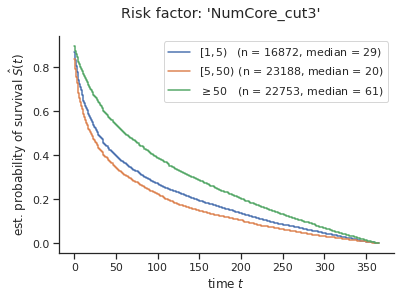

In [1042]:
plot_survival_function(params, ddf, condition_names=values_names)

In [1043]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

<AxesSubplot: xlabel='NumCore', ylabel='Y'>

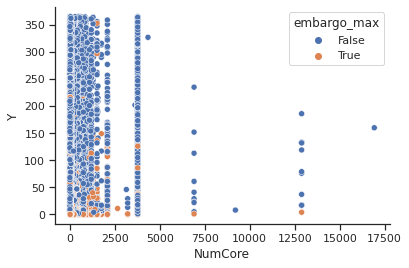

In [1044]:
sns.scatterplot(data=df, x='NumCore', y='Y', hue='embargo_max')

-----
**NumAuthors**

[None, None]

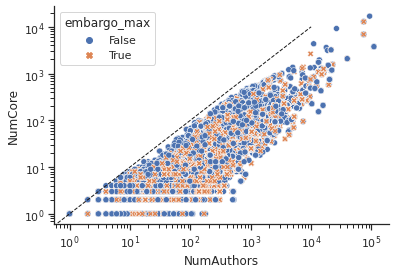

In [1045]:
splot = sns.scatterplot(data=df,x='NumAuthors',y='NumCore',
                        hue='embargo_max', style='embargo_max')
ax = plt.gca()
ax.plot([0,1e4], [0,1e4], linestyle='--', color='k', lw=1, scalex=False, scaley=False)
splot.set(xscale="log",yscale="log")
plt.show()

<AxesSubplot: ylabel='Count'>

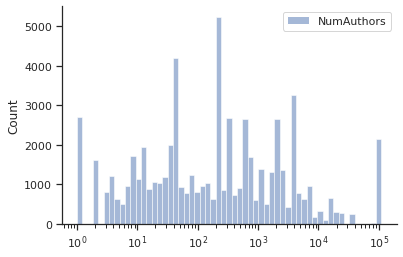

In [1046]:
sns.histplot(data=df[['NumAuthors']].dropna(),log_scale=True)

/tmp/ipykernel_3850516/2779414870.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumAuthors_cut5
[1.0, 4.0)          5132
[4.0, 6.0)          1832
[6.0, 100.0)       20134
[100.0, 1000.0)    18035
[1000.0, inf)      17680
dtype: int64

CategoricalDtype(categories=[[1.0, 4.0), [4.0, 6.0), [6.0, 100.0), [100.0, 1000.0), [1000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumAuthors_cut5', ylabel='CVE+project'>

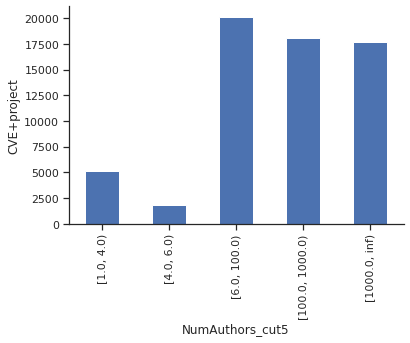

In [1047]:
column_name = 'NumAuthors'
column_cut = column_name + '_cut5'

cut_s = pd.cut(df[column_name].dropna(),
               bins=[1,4,6,100,1e3,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [1048]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(1.0, 4.0, closed='left'),
 1: Interval(4.0, 6.0, closed='left'),
 2: Interval(6.0, 100.0, closed='left'),
 3: Interval(100.0, 1000.0, closed='left'),
 4: Interval(1000.0, inf, closed='left')}

In [1049]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 62866, selected = 62813, uncensored = 62813
Computing 100 × bootstrap Dxy for 62813 elements...
Computing confidence interval from 100 samples...


{
    "Cohort": 62866,
    "Number of patients": 62813.0,
    "% of cohort": 99.91569369770623,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.09038010516190864,
    "bootstrap": {
        "Dxy": 0.08981355830074479,
        "Confidence interval low": 0.08929923160378954,
        "Confidence interval high": 0.09032788499770004,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


Computing descriptive statistics like mean, median, etc....


count  median  min   25%    75%  max        mean         std  \
NumAuthors_cut5                                                                 
[1.0, 4.0)        5132    38.0    0   7.0  136.0  365   84.029423   98.919030   
[4.0, 6.0)        1832    55.0    0  11.0  168.0  365   98.624454  103.639519   
[6.0, 100.0)     20134    19.0    0   2.0   85.0  365   61.874789   88.082815   
[100.0, 1000.0)  18035    28.0    0   5.0  105.0  365   69.926754   90.199154   
[1000.0, inf)    17680    68.0    0  15.0  182.0  365  106.719627  106.546102   

                     skew  % of cohort  % of selected  % of patients     IR  
NumAuthors_cut5                                                              
[1.0, 4.0)       1.226251     8.163395       8.170283       8.170283  129.0  
[4.0, 6.0)       0.975107     2.914135       2.916594       2.916594  157.0  
[6.0, 100.0)     1.696369    32.026851      32.053874      32.053874   83.0  
[100.0, 1000.0)  1.528197    28.688003      28.712209      28.712209  100.0  
[1000.0, inf)    0.840387    28.123310      28.147040      28.147040  167.0

In [1050]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

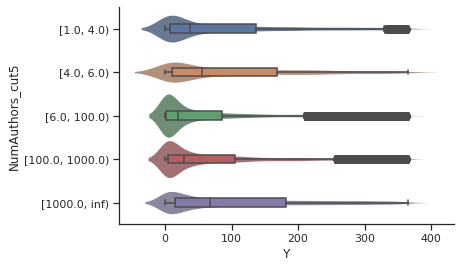

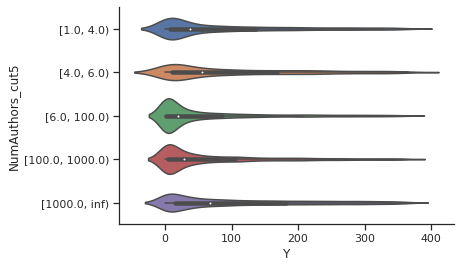

In [1051]:
ax = sns.violinplot(data=df, x="Y", y=column_cut,
                    inner=None, width=1.0, linewidth=0, saturation=0.4)
sns.boxplot(data=df, x="Y", y=column_cut,
            width=0.2, boxprops={'zorder': 2}, ax=ax)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

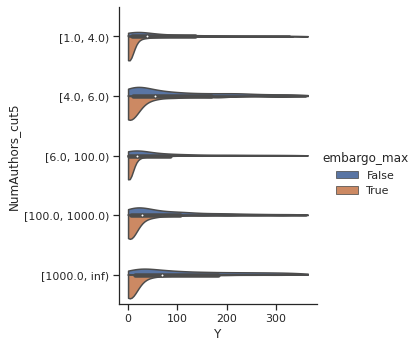

In [1052]:
sns.catplot(
    data=df, x="Y", y=column_cut, hue="embargo_max",
    kind="violin", bw=.25, cut=0, split=True,
)

values_list = dict_keys([0, 1, 2, 3, 4])


Saved survival function plot to 'NumAuthors_cut5.svg' and *.pdf


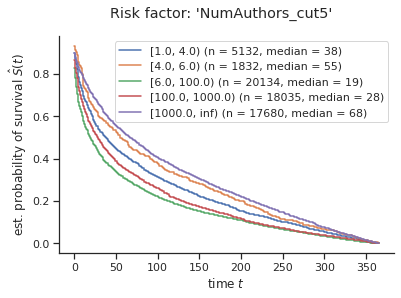

In [1053]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

-----

/tmp/ipykernel_3850516/3645709497.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumAuthors_cut3
[1.0, 100.0)       27098
[100.0, 1000.0)    18035
[1000.0, inf)      17680
dtype: int64

CategoricalDtype(categories=[[1.0, 100.0), [100.0, 1000.0), [1000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumAuthors_cut3', ylabel='CVE+project'>

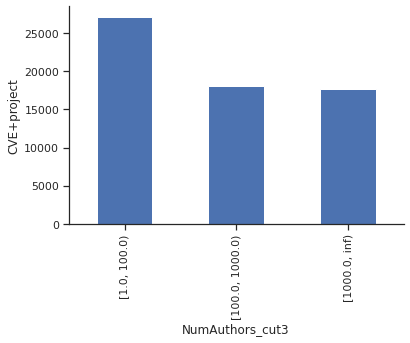

In [1054]:
column_name = 'NumAuthors'
column_cut = column_name + '_cut3'

cut_s = pd.cut(df[column_name].dropna(),
               bins=[1,1e2,1e3,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [1055]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 62866, selected = 62813, uncensored = 62813
Computing 100 × bootstrap Dxy for 62813 elements...
Computing confidence interval from 100 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62813.0,
    "% of cohort": 99.91569369770623,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.10404166495886291,
    "bootstrap": {
        "Dxy": 0.10408117727797218,
        "Confidence interval low": 0.10356124084248679,
        "Confidence interval high": 0.10460111371345758,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


count  median  min   25%    75%  max        mean         std  \
NumAuthors_cut3                                                                 
[1.0, 100.0)     27098    24.0    0   3.0  100.0  365   68.555096   92.102654   
[100.0, 1000.0)  18035    28.0    0   5.0  105.0  365   69.926754   90.199154   
[1000.0, inf)    17680    68.0    0  15.0  182.0  365  106.719627  106.546102   

                     skew  % of cohort  % of selected  % of patients     IR  
NumAuthors_cut3                                                              
[1.0, 100.0)     1.532791    43.104381      43.140751      43.140751   97.0  
[100.0, 1000.0)  1.528197    28.688003      28.712209      28.712209  100.0  
[1000.0, inf)    0.840387    28.123310      28.147040      28.147040  167.0

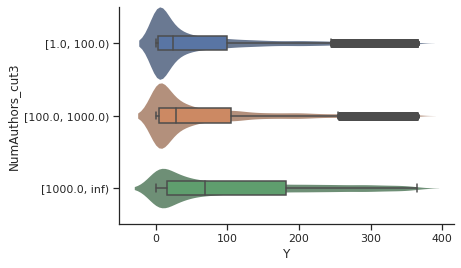

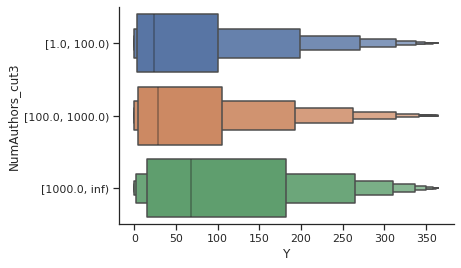

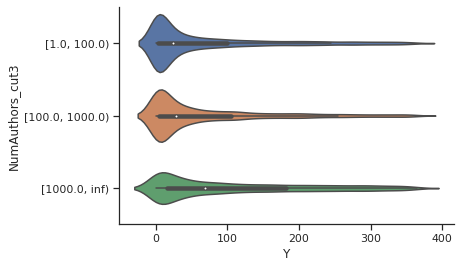

In [1056]:
ax = sns.violinplot(data=df, x="Y", y=column_cut,
                    inner=None, width=1.0, linewidth=0, saturation=0.4)
sns.boxplot(data=df, x="Y", y=column_cut,
            width=0.2, boxprops={'zorder': 2}, ax=ax)
plt.show();
sns.boxenplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

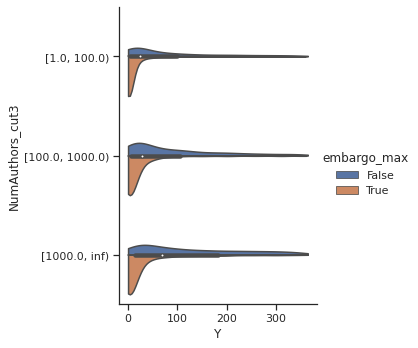

In [1057]:
sns.catplot(
    data=df, x="Y", y=column_cut, hue="embargo_max",
    kind="violin", bw=.25, cut=0, split=True,
)

values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'NumAuthors_cut3.svg' and *.pdf


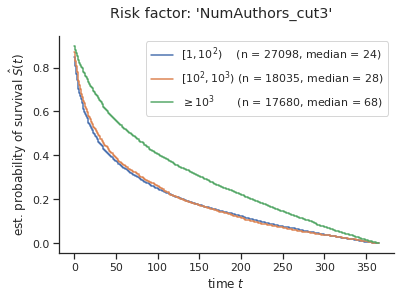

In [1058]:
values_names={0: r'$[1, 10^2)\ \ \,\,$', 1: r'$[10^2, 10^3)$', 2: r'$\geq 10^3\ \ \ \ \ \,$'}
plot_survival_function(params, ddf, condition_names=values_names)

In [1059]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

---
cut2

/tmp/ipykernel_3850516/2012612121.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumAuthors_cut2
[1.0, 1000.0)    45133
[1000.0, inf)    17680
dtype: int64

CategoricalDtype(categories=[[1.0, 1000.0), [1000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumAuthors_cut2', ylabel='CVE+project'>

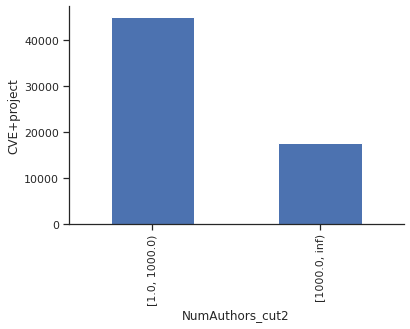

In [1060]:
column_name = 'NumAuthors'
column_cut = column_name + '_cut2'

cut_s = pd.cut(df[column_name].dropna(),
               bins=[1,1e3,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [1061]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 62866, selected = 62813, uncensored = 62813
Computing 100 × bootstrap Dxy for 62813 elements...
Computing confidence interval from 100 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62813.0,
    "% of cohort": 99.91569369770623,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.0955131902630657,
    "bootstrap": {
        "Dxy": 0.0956440417921221,
        "Confidence interval low": 0.09521369274053691,
        "Confidence interval high": 0.0960743908437073,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


count  median  min   25%    75%  max        mean         std  \
NumAuthors_cut2                                                                 
[1.0, 1000.0)    45133    26.0    0   4.0  102.0  365   69.103206   91.348248   
[1000.0, inf)    17680    68.0    0  15.0  182.0  365  106.719627  106.546102   

                     skew  % of cohort  % of selected  % of patients     IR  
NumAuthors_cut2                                                              
[1.0, 1000.0)    1.530639    71.792384       71.85296       71.85296   98.0  
[1000.0, inf)    0.840387    28.123310       28.14704       28.14704  167.0

{0: Interval(1.0, 1000.0, closed='left'), 1: Interval(1000.0, inf, closed='left')}
values_list = dict_keys([0, 1])


Saved survival function plot to 'NumAuthors_cut2.svg' and *.pdf


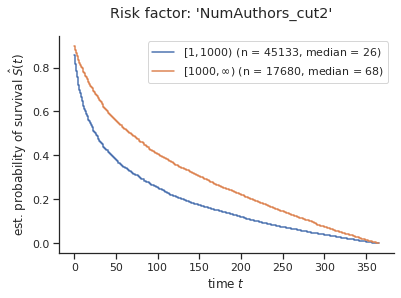

In [1062]:
print(values_names)
plot_survival_function(params, ddf, condition_names={0: r'$[1, 1000)$', 1: r'$[1000, \infty)$'})

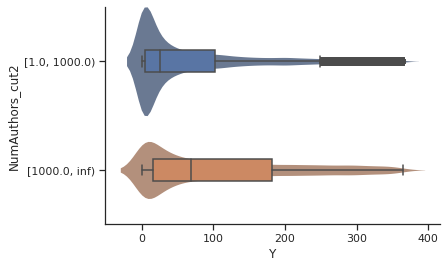

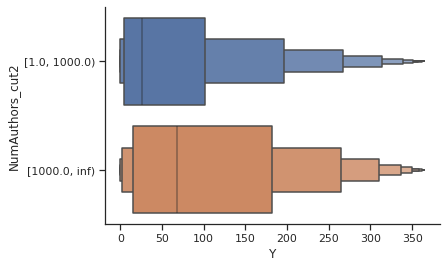

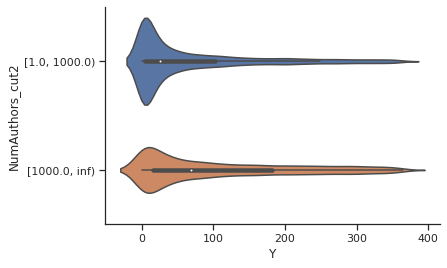

In [1063]:
ax = sns.violinplot(data=df, x="Y", y=column_cut,
                    inner=None, width=1.0, linewidth=0, saturation=0.4)
sns.boxplot(data=df, x="Y", y=column_cut,
            width=0.2, boxprops={'zorder': 2}, ax=ax)
plt.show();
sns.boxenplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

In [1064]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

----
**Summary**

<AxesSubplot: xlabel='NumAuthors', ylabel='Y'>

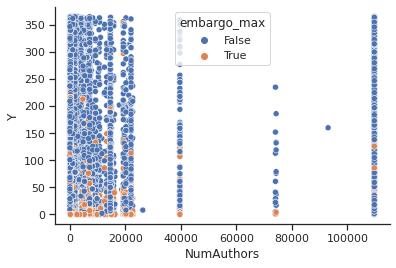

In [1065]:
sns.scatterplot(data=df, x='NumAuthors', y='Y', hue='embargo_max')

<AxesSubplot: xlabel='NumAuthors', ylabel='Y'>

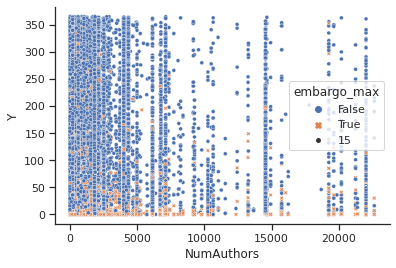

In [1066]:
sns.scatterplot(data=df[df['NumAuthors']<25000],
                x='NumAuthors', y='Y',
                hue='embargo_max', style='embargo_max',
                size=15,sizes=(15,15))

### NumCore / NumAuthors

<AxesSubplot: xlabel='NumAuthors', ylabel='NumCore'>

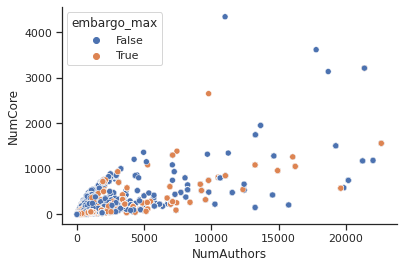

In [1067]:
sns.scatterplot(data=df[df['NumAuthors']<25000], x='NumAuthors', y='NumCore', hue='embargo_max')

<AxesSubplot: xlabel='NumAuthors', ylabel='NumCore'>

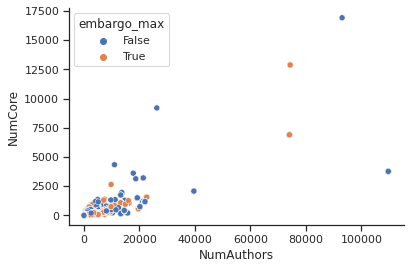

In [1068]:
sns.scatterplot(data=df, x='NumAuthors', y='NumCore', hue='embargo_max')

In [1069]:
df['NumCore/NumAuthors'] = df['NumCore'] / df['NumAuthors']
df['NumCore/NumAuthors'].describe()

/tmp/ipykernel_3850516/998512510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NumCore/NumAuthors'] = df['NumCore'] / df['NumAuthors']


count    62813.000000
mean         0.207294
std          0.235437
min          0.003810
25%          0.053170
50%          0.111111
75%          0.257732
max          1.000000
Name: NumCore/NumAuthors, dtype: float64

In [1070]:
df['NumCore/NumAuthors'][df['NumAuthors'] > 4].describe()

count    56476.000000
mean         0.148022
std          0.133745
min          0.003810
25%          0.053170
50%          0.104918
75%          0.187500
max          0.875000
Name: NumCore/NumAuthors, dtype: float64

<AxesSubplot: ylabel='Count'>

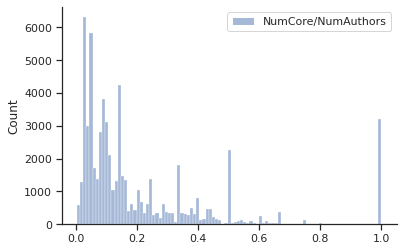

In [1071]:
sns.histplot(data=df[['NumCore/NumAuthors']].dropna())

<AxesSubplot: ylabel='Count'>

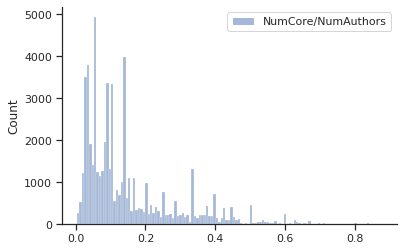

In [1072]:
sns.histplot(data=df[['NumCore/NumAuthors']][df['NumAuthors']>4].dropna())

/tmp/ipykernel_3850516/4082952862.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumCore/NumAuthors cut3
[0.0, 0.333)      49470
[0.333, 0.667)     9508
[0.667, 1.001)     3835
dtype: int64

CategoricalDtype(categories=[[0.0, 0.333), [0.333, 0.667), [0.667, 1.001)], ordered=True)

<AxesSubplot: xlabel='NumCore/NumAuthors cut3', ylabel='CVE+project'>

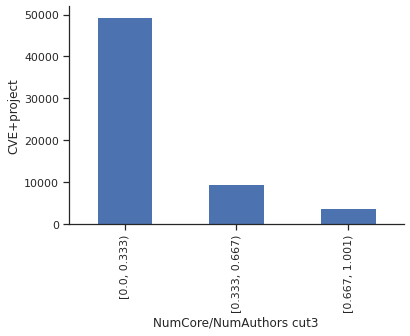

In [1073]:
column_name = 'NumCore/NumAuthors'
column_cut = column_name + ' cut3'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[0,1.0/3.0,2.0/3.0,1.001],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [1074]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(0.0, 0.333, closed='left'),
 1: Interval(0.333, 0.667, closed='left'),
 2: Interval(0.667, 1.001, closed='left')}

In [1075]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 62866, selected = 62813, uncensored = 62813
Computing 100 × bootstrap Dxy for 62813 elements...
Computing confidence interval from 100 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62813.0,
    "% of cohort": 99.91569369770623,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.052208379907902724,
    "bootstrap": {
        "Dxy": 0.05214226833791142,
        "Confidence interval low": 0.0517869471486661,
        "Confidence interval high": 0.05249758952715674,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


count  median  min   25%    75%  max        mean  \
NumCore/NumAuthors cut3                                                     
[0.0, 0.333)             49470    30.0    0   4.0  112.0  365   74.290418   
[0.333, 0.667)            9508    68.0    0  13.0  186.0  365  107.461191   
[0.667, 1.001)            3835    34.0    0   7.0  127.0  365   80.508475   

                                std      skew  % of cohort  % of selected  \
NumCore/NumAuthors cut3                                                     
[0.0, 0.333)              94.340897  1.411986    78.691184      78.757582   
[0.333, 0.667)           107.176217  0.815713    15.124232      15.136994   
[0.667, 1.001)            98.245403  1.317157     6.100277       6.105424   

                         % of patients     IR  
NumCore/NumAuthors cut3                        
[0.0, 0.333)                 78.757582  108.0  
[0.333, 0.667)               15.136994  173.0  
[0.667, 1.001)                6.105424  120.0

In [1076]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

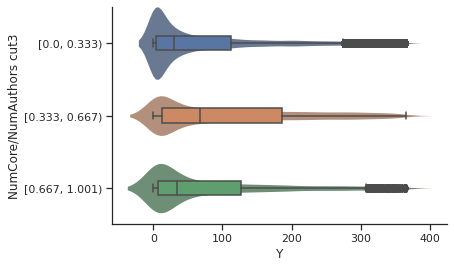

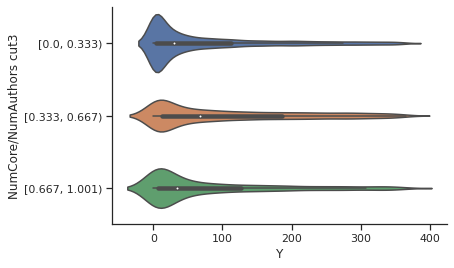

In [1077]:
ax = sns.violinplot(data=df, x="Y", y=column_cut,
                    inner=None, width=1.0, linewidth=0, saturation=0.4)
sns.boxplot(data=df, x="Y", y=column_cut,
            width=0.2, boxprops={'zorder': 2}, ax=ax)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

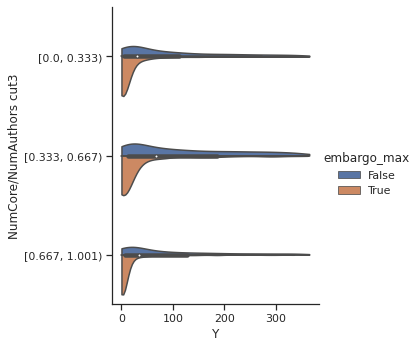

In [1078]:
sns.catplot(
    data=df, x="Y", y=column_cut, hue="embargo_max",
    kind="violin", bw=.25, cut=0, split=True,
)

{0: Interval(0.0, 0.333, closed='left'), 1: Interval(0.333, 0.667, closed='left'), 2: Interval(0.667, 1.001, closed='left')}
dict_keys([0, 1, 2])
values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'NumCore to NumAuthors ratio - cut3.svg' and *.pdf


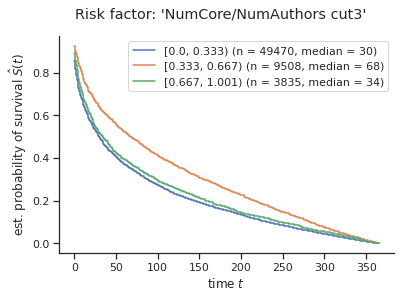

In [1079]:
print(values_names)
print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names, plot_basename='NumCore to NumAuthors ratio - cut3')

<AxesSubplot: xlabel='Y', ylabel='NumCore/NumAuthors'>

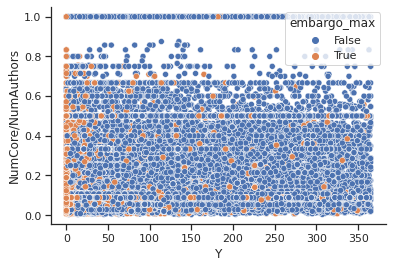

In [1080]:
sns.scatterplot(data=df, y=column_name, x='Y', hue='embargo_max')

<AxesSubplot: xlabel='Y', ylabel='NumCore/NumAuthors'>

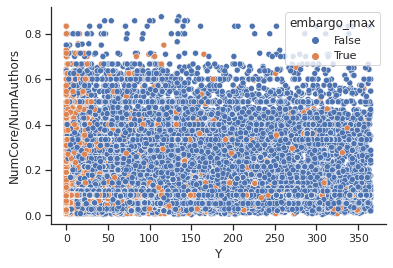

In [1081]:
sns.scatterplot(data=df[df['NumAuthors']>4], y=column_name, x='Y', hue='embargo_max')

### NumCommits

<AxesSubplot: ylabel='Count'>

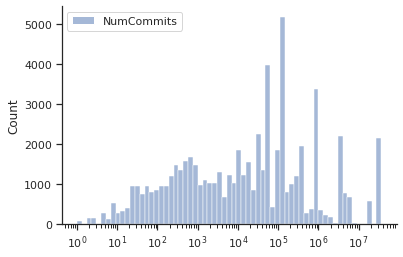

In [1082]:
sns.histplot(data=df[['NumCommits']].dropna(), log_scale=True)

/tmp/ipykernel_3850516/3920164987.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumCommits_cut7
[1.0, 10.0)               1232
[10.0, 100.0)             5837
[100.0, 1000.0)          10731
[1000.0, 10000.0)         8754
[10000.0, 100000.0)      14850
[100000.0, 1000000.0)    14248
[1000000.0, inf)          7107
dtype: int64

CategoricalDtype(categories=[[1.0, 10.0), [10.0, 100.0), [100.0, 1000.0), [1000.0, 10000.0), [10000.0, 100000.0), [100000.0, 1000000.0), [1000000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumCommits_cut7', ylabel='CVE+project'>

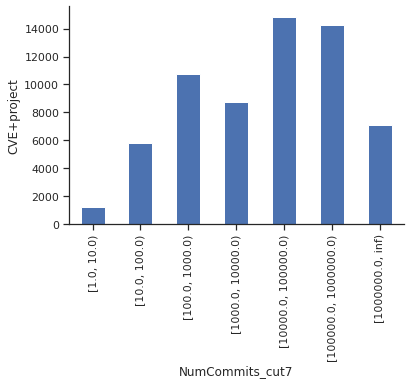

In [1083]:
column_name = 'NumCommits'
column_cut = column_name + '_cut7'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,10,100,1000,10000,100000,1000000,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

all = 62866, selected = 62759, uncensored = 62759
Computing 100 × bootstrap Dxy for 62759 elements...
Computing confidence interval from 100 samples...


{
    "Cohort": 62866,
    "Number of patients": 62759.0,
    "% of cohort": 99.82979671046353,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.0011505664254758408,
    "bootstrap": {
        "Dxy": 0.0011941118733077504,
        "Confidence interval low": 0.0006451393077751146,
        "Confidence interval high": 0.0017430844388403861,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


Computing descriptive statistics like mean, median, etc....


count  median  min   25%     75%  max       mean  \
NumCommits_cut7                                                           
[1.0, 10.0)             1232    52.0    0   9.0  163.25  365  98.549513   
[10.0, 100.0)           5837    41.0    0   9.0  131.00  365  84.054994   
[100.0, 1000.0)        10731    32.0    0   6.0  117.00  365  76.964402   
[1000.0, 10000.0)       8754    52.0    0   7.0  167.00  365  95.933859   
[10000.0, 100000.0)    14850    19.0    0   2.0   86.00  365  60.390505   
[100000.0, 1000000.0)  14248    36.0    0   7.0  129.00  365  82.780250   
[1000000.0, inf)        7107    50.0    0  11.0  149.00  365  91.064303   

                              std      skew  % of cohort  % of selected  \
NumCommits_cut7                                                           
[1.0, 10.0)            105.512932  0.945317     1.959724       1.963065   
[10.0, 100.0)           97.823570  1.244068     9.284828       9.300658   
[100.0, 1000.0)         95.577261  1.353958    17.069640      17.098743   
[1000.0, 10000.0)      105.385474  0.971410    13.924856      13.948597   
[10000.0, 100000.0)     85.732778  1.718651    23.621671      23.661945   
[100000.0, 1000000.0)   99.339239  1.262593    22.664079      22.702720   
[1000000.0, inf)        99.875980  1.118998    11.304998      11.324272   

                       % of patients      IR  
NumCommits_cut7                               
[1.0, 10.0)                 1.963065  154.25  
[10.0, 100.0)               9.300658  122.00  
[100.0, 1000.0)            17.098743  111.00  
[1000.0, 10000.0)          13.948597  160.00  
[10000.0, 100000.0)        23.661945   84.00  
[100000.0, 1000000.0)      22.702720  122.00  
[1000000.0, inf)           11.324272  138.00

values_list = dict_keys([0, 1, 2, 3, 4, 5, 6])


Saved survival function plot to 'NumCommits_cut7.svg' and *.pdf


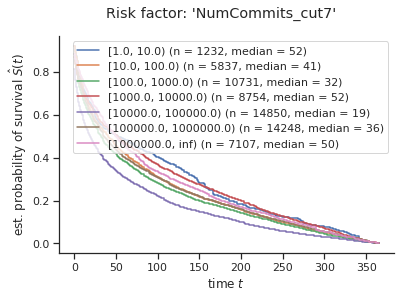

In [1084]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

In [1085]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

<AxesSubplot: xlabel='Y', ylabel='NumCommits_cut7'>

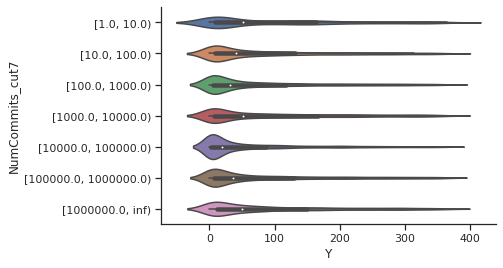

In [1086]:
sns.violinplot(data=df, x="Y", y=column_cut)

/tmp/ipykernel_3850516/1578640245.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumCommits_cut3
[1.0, 1000.0)         17800
[1000.0, 100000.0)    23604
[100000.0, inf)       21355
dtype: int64

CategoricalDtype(categories=[[1.0, 1000.0), [1000.0, 100000.0), [100000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumCommits_cut3', ylabel='CVE+project'>

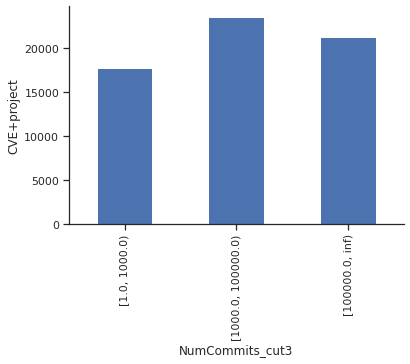

In [1087]:
column_name = 'NumCommits'
column_cut = column_name + '_cut3'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,1000,100000,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

all = 62866, selected = 62759, uncensored = 62759
Computing 100 × bootstrap Dxy for 62759 elements...
Computing confidence interval from 100 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62759.0,
    "% of cohort": 99.82979671046353,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.014771696118363709,
    "bootstrap": {
        "Dxy": 0.014617702803165242,
        "Confidence interval low": 0.014172315970364207,
        "Confidence interval high": 0.015063089635966278,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


count  median  min  25%    75%  max       mean        std  \
NumCommits_cut3                                                                 
[1.0, 1000.0)       17800    35.0    0  7.0  127.0  365  80.783539  97.204752   
[1000.0, 100000.0)  23604    27.0    0  3.0  112.0  365  73.572445  95.065547   
[100000.0, inf)     21355    41.0    0  8.0  136.0  365  85.537204  99.592385   

                        skew  % of cohort  % of selected  % of patients     IR  
NumCommits_cut3                                                                 
[1.0, 1000.0)       1.284907    28.314192      28.362466      28.362466  120.0  
[1000.0, 100000.0)  1.395582    37.546528      37.610542      37.610542  109.0  
[100000.0, inf)     1.212059    33.969077      34.026992      34.026992  128.0

values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'NumCommits_cut3.svg' and *.pdf


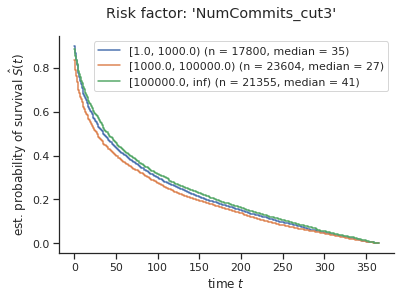

In [1088]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

In [1089]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

<AxesSubplot: xlabel='Y', ylabel='NumCommits_cut3'>

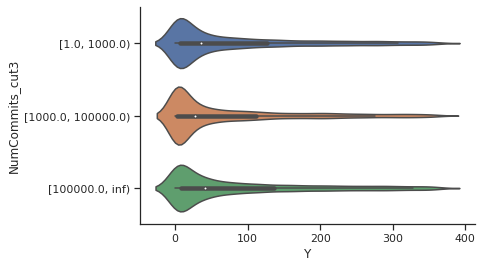

In [1090]:
sns.violinplot(data=df, x="Y", y=column_cut)

<AxesSubplot: xlabel='NumCommits', ylabel='Y'>

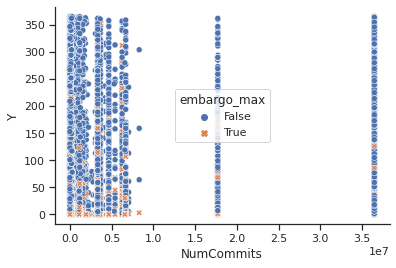

In [1091]:
sns.scatterplot(data=df, x='NumCommits', y='Y', hue='embargo_max', style='embargo_max')

<AxesSubplot: xlabel='NumCommits', ylabel='Y'>

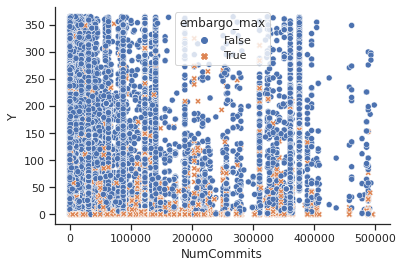

In [1092]:
sns.scatterplot(data=df[df['NumCommits']<0.5e6], x='NumCommits', y='Y', hue='embargo_max', style='embargo_max')

### NumMon and ActiveMon \[%]

In [1093]:
df['CommitDateRange']=df['LatestCommitDate']-df['EarliestCommitDate']
df['CommitDateRange [days]']=df['CommitDateRange'].dt.days
df['CommitDateRange [mon]']=\
12 * (df['LatestCommitDate'].dt.year  - df['EarliestCommitDate'].dt.year) +\
     (df['LatestCommitDate'].dt.month - df['EarliestCommitDate'].dt.month)

df[['CommitDateRange [days]', 'CommitDateRange [mon]']].describe()

/tmp/ipykernel_3850516/2436893064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CommitDateRange']=df['LatestCommitDate']-df['EarliestCommitDate']
/tmp/ipykernel_3850516/2436893064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CommitDateRange [days]']=df['CommitDateRange'].dt.days
/tmp/ipykernel_3850516/2436893064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

CommitDateRange [days]  CommitDateRange [mon]
count            62866.000000           62866.000000
mean              6738.244584             221.379442
std               7475.956657             245.568813
min                  0.000000               0.000000
25%               2382.000000              78.000000
50%               4486.000000             147.000000
75%               8247.000000             271.000000
max              81273.000000            2671.000000

<AxesSubplot: xlabel='CommitDateRange [days]', ylabel='NumActiveMon'>

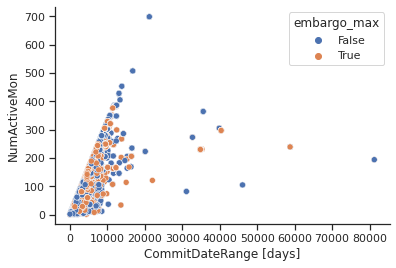

In [1094]:
sns.scatterplot(data=df, x='CommitDateRange [days]', y='NumActiveMon', hue='embargo_max')

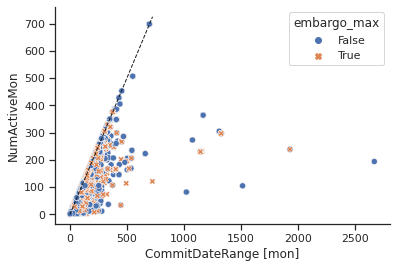

In [1095]:
g = sns.scatterplot(data=df, x='CommitDateRange [mon]', y='NumActiveMon',
                    hue='embargo_max', style='embargo_max')
ax = plt.gca()
ax.plot([0,725], [0,725], linestyle='--', color='k', lw=1, scalex=False, scaley=False)

<AxesSubplot: xlabel='CommitDateRange [days]', ylabel='CommitDateRange [mon]'>

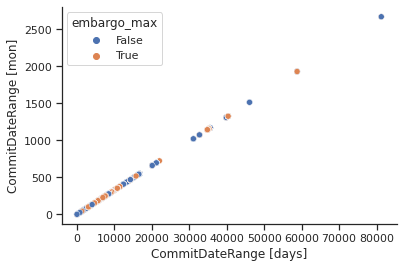

In [1096]:
sns.scatterplot(data=df, x='CommitDateRange [days]', y='CommitDateRange [mon]', hue='embargo_max')

In [1097]:
mon_mask=df['NumActiveMon']<=(df['CommitDateRange [mon]']+2)
display(mon_mask.value_counts())

df[~mon_mask][['project_names','CommitDateRange [mon]','NumActiveMon']].head()

True    62866
dtype: Int64

Empty DataFrame
Columns: [project_names, CommitDateRange [mon], NumActiveMon]
Index: []

In [1098]:
df['NumActiveMon [%]']=100.0*df['NumActiveMon']/(df['CommitDateRange [mon]']+2)
df[['NumActiveMon [%]']].describe()

/tmp/ipykernel_3850516/2274642494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NumActiveMon [%]']=100.0*df['NumActiveMon']/(df['CommitDateRange [mon]']+2)


NumActiveMon [%]
count      62866.000000
mean          73.168076
std           26.910081
min            1.369863
25%           50.000000
50%           83.408072
75%           98.765432
max          100.000000

<AxesSubplot: ylabel='Count'>

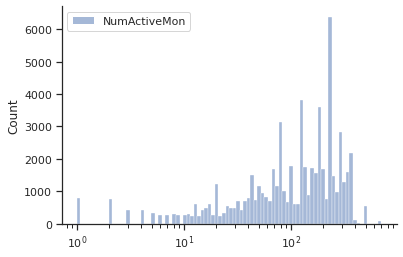

In [1099]:
sns.histplot(data=df[['NumActiveMon']].dropna(), log_scale=True)

<AxesSubplot: ylabel='Count'>

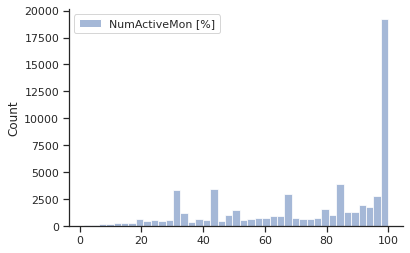

In [1100]:
sns.histplot(data=df[['NumActiveMon [%]']].dropna())

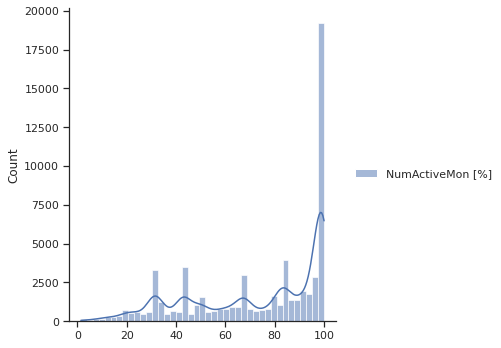

In [1101]:
sns.displot(data=df[['NumActiveMon [%]']], kde=True)

/tmp/ipykernel_3850516/2751692320.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumActiveMon [%] cut4
[0.0, 25.0)        3121
[25.0, 50.0)      12571
[50.0, 75.0)      10945
[75.0, 100.01)    36229
dtype: int64

CategoricalDtype(categories=[[0.0, 25.0), [25.0, 50.0), [50.0, 75.0), [75.0, 100.01)], ordered=True)

<AxesSubplot: xlabel='NumActiveMon [%] cut4', ylabel='CVE+project'>

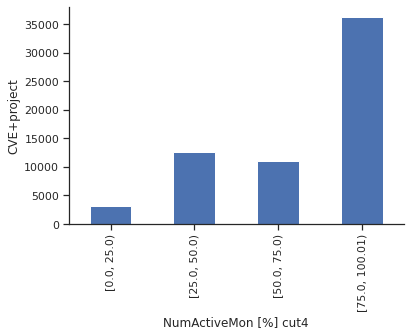

In [1102]:
column_name = 'NumActiveMon [%]'
column_cut = column_name + ' cut4'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[0,25,50,75,100.01],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

all = 62866, selected = 62866, uncensored = 62866
Computing 100 × bootstrap Dxy for 62866 elements...
Computing confidence interval from 100 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62866.0,
    "% of cohort": 100.0,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": -0.08940879659063439,
    "bootstrap": {
        "Dxy": -0.08894976502879931,
        "Confidence interval low": -0.08941172198597856,
        "Confidence interval high": -0.08848780807162006,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


count  median  min   25%    75%  max        mean  \
NumActiveMon [%] cut4                                                     
[0.0, 25.0)             3121    36.0    0   5.0  141.0  365   85.714515   
[25.0, 50.0)           12571    72.0    0  18.0  181.0  365  107.083526   
[50.0, 75.0)           10945    33.0    0   4.0  129.0  365   80.420283   
[75.0, 100.01)         36229    26.0    0   4.0  102.0  365   69.428220   

                              std      skew  % of cohort  % of selected  \
NumActiveMon [%] cut4                                                     
[0.0, 25.0)            101.895325  1.180351     4.964528       4.964528   
[25.0, 50.0)           104.235231  0.847689    19.996500      19.996500   
[50.0, 75.0)            98.637400  1.277858    17.410047      17.410047   
[75.0, 100.01)          92.045001  1.525687    57.628925      57.628925   

                       % of patients     IR  
NumActiveMon [%] cut4                        
[0.0, 25.0)                 4.964528  136.0  
[25.0, 50.0)               19.996500  163.0  
[50.0, 75.0)               17.410047  125.0  
[75.0, 100.01)             57.628925   98.0

values_list = dict_keys([0, 1, 2, 3])


Saved survival function plot to 'NumActiveMon [%] cut4.svg' and *.pdf


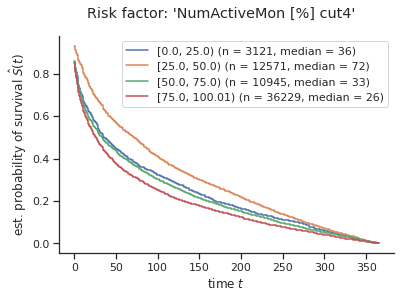

In [1103]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

In [1104]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

<AxesSubplot: xlabel='Y', ylabel='NumActiveMon [%] cut4'>

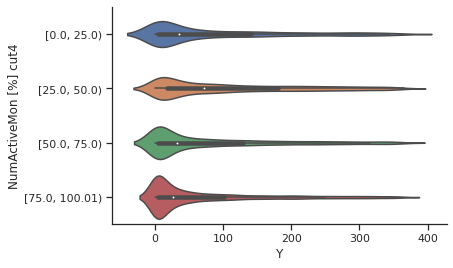

In [1105]:
sns.violinplot(data=df, x="Y", y=column_cut)

----

/tmp/ipykernel_3850516/3720764190.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumActiveMon [%] cut3
[0.0, 33.33)        7842
[33.33, 66.66)     14107
[66.66, 100.01)    40917
dtype: int64

CategoricalDtype(categories=[[0.0, 33.33), [33.33, 66.66), [66.66, 100.01)], ordered=True)

<AxesSubplot: xlabel='NumActiveMon [%] cut3', ylabel='CVE+project'>

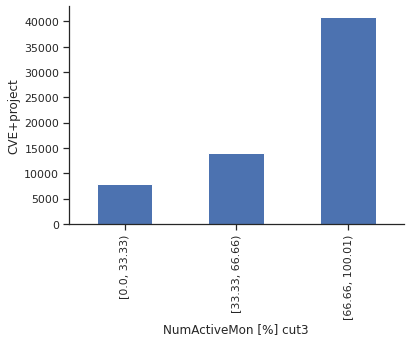

In [1106]:
column_name = 'NumActiveMon [%]'
column_cut = column_name + ' cut3'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[0,33.33,66.66,100.01],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

all = 62866, selected = 62866, uncensored = 62866
Computing 100 × bootstrap Dxy for 62866 elements...
Computing confidence interval from 100 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62866.0,
    "% of cohort": 100.0,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": -0.086423190067339,
    "bootstrap": {
        "Dxy": -0.08611511548934084,
        "Confidence interval low": -0.08661111867225324,
        "Confidence interval high": -0.08561911230642844,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


count  median  min   25%    75%  max       mean  \
NumActiveMon [%] cut3                                                    
[0.0, 33.33)            7842    56.0    0  12.0  161.0  365  97.732339   
[33.33, 66.66)         14107    57.0    0  11.0  167.0  365  98.439569   
[66.66, 100.01)        40917    26.0    0   4.0  103.0  365  69.752743   

                              std      skew  % of cohort  % of selected  \
NumActiveMon [%] cut3                                                     
[0.0, 33.33)           103.754302  1.006047    12.474151      12.474151   
[33.33, 66.66)         103.727157  0.950771    22.439793      22.439793   
[66.66, 100.01)         92.225709  1.517033    65.086056      65.086056   

                       % of patients     IR  
NumActiveMon [%] cut3                        
[0.0, 33.33)               12.474151  149.0  
[33.33, 66.66)             22.439793  156.0  
[66.66, 100.01)            65.086056   99.0

values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'NumActiveMon [%] cut3.svg' and *.pdf


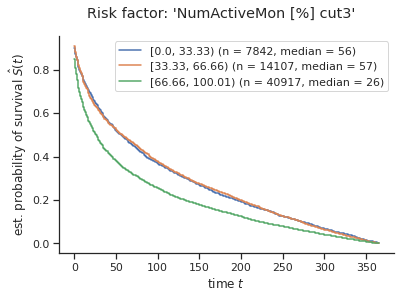

In [1107]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='Y', ylabel='NumActiveMon [%] cut3'>

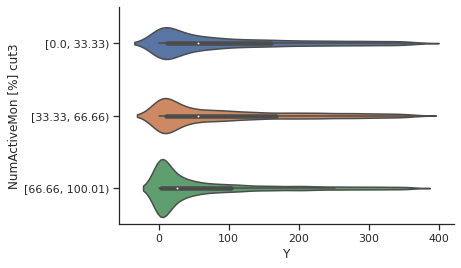

In [1108]:
sns.violinplot(data=df, x="Y", y=column_cut)

In [1109]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

----

/tmp/ipykernel_3850516/4193611193.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumActiveMon [%] cut3b
[0.0, 50.0)       15692
[50.0, 85.0)      18399
[85.0, 100.01)    28775
dtype: int64

CategoricalDtype(categories=[[0.0, 50.0), [50.0, 85.0), [85.0, 100.01)], ordered=True)

<AxesSubplot: xlabel='NumActiveMon [%] cut3b', ylabel='CVE+project'>

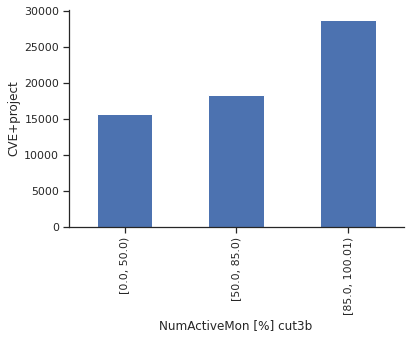

In [1110]:
column_name = 'NumActiveMon [%]'
column_cut = column_name + ' cut3b'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[0,50,85,100.01],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

all = 62866, selected = 62866, uncensored = 62866
Computing 100 × bootstrap Dxy for 62866 elements...
Computing confidence interval from 100 samples...


{
    "Cohort": 62866,
    "Number of patients": 62866.0,
    "% of cohort": 100.0,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": -0.10387218552132171,
    "bootstrap": {
        "Dxy": -0.10375813018531418,
        "Confidence interval low": -0.1042175587153856,
        "Confidence interval high": -0.10329870165524277,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


Computing descriptive statistics like mean, median, etc....


count  median  min   25%    75%  max        mean  \
NumActiveMon [%] cut3b                                                     
[0.0, 50.0)             15692    64.0    0  15.0  173.0  365  102.833418   
[50.0, 85.0)            18399    32.0    0   5.0  129.0  365   80.833904   
[85.0, 100.01)          28775    25.0    0   3.0   97.0  365   66.316316   

                               std      skew  % of cohort  % of selected  \
NumActiveMon [%] cut3b                                                     
[0.0, 50.0)             104.120829  0.904716    24.961028      24.961028   
[50.0, 85.0)            100.246361  1.290683    29.267012      29.267012   
[85.0, 100.01)           88.854517  1.580156    45.771959      45.771959   

                        % of patients     IR  
NumActiveMon [%] cut3b                        
[0.0, 50.0)                 24.961028  158.0  
[50.0, 85.0)                29.267012  124.0  
[85.0, 100.01)              45.771959   94.0

values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'NumActiveMon [%] cut3b.svg' and *.pdf


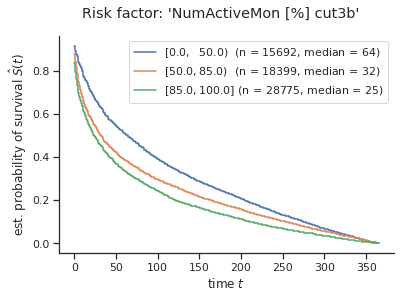

In [1111]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

values_names={0: r'$[0.0,\ \ 50.0)\ $', 1: r'$[50.0, 85.0)\ $', 2: r'$[85.0, 100.0]$'}
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='Y', ylabel='NumActiveMon [%] cut3b'>

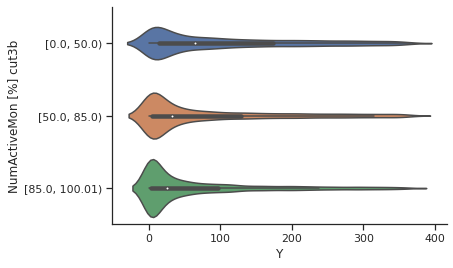

In [1112]:
sns.violinplot(data=df, x="Y", y=column_cut)

In [1113]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

----

----

<AxesSubplot: xlabel='NumActiveMon [%]', ylabel='Y'>

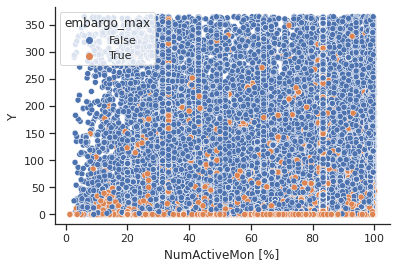

In [1114]:
sns.scatterplot(data=df, x='NumActiveMon [%]', y='Y', hue='embargo_max')

<AxesSubplot: xlabel='NumActiveMon [%]', ylabel='Y'>

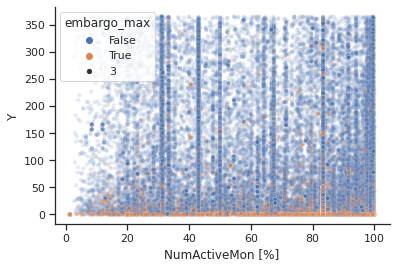

In [1115]:
sns.scatterplot(data=df, x='NumActiveMon [%]', y='Y', hue='embargo_max',size=3,alpha=0.15)

##### NumActiveMon

/tmp/ipykernel_3850516/2071987209.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumActiveMon_cut3
[1, 10)         3805
[10, 100)      23106
[100, 1000)    35955
dtype: int64

CategoricalDtype(categories=[[1, 10), [10, 100), [100, 1000)], ordered=True)

<AxesSubplot: xlabel='NumActiveMon_cut3', ylabel='CVE+project'>

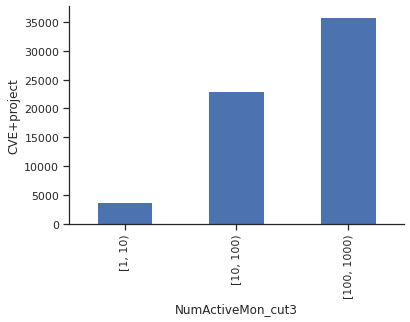

In [1116]:
column_name = 'NumActiveMon'
column_cut = column_name + '_cut3'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,10,100,1000],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [1117]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

print(values_names)

{0: Interval(1, 10, closed='left'), 1: Interval(10, 100, closed='left'), 2: Interval(100, 1000, closed='left')}


all = 62866, selected = 62866, uncensored = 62866
Computing 100 × bootstrap Dxy for 62866 elements...
Computing confidence interval from 100 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62866.0,
    "% of cohort": 100.0,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": -0.07727737172653504,
    "bootstrap": {
        "Dxy": -0.07746431023771691,
        "Confidence interval low": -0.07795284442594601,
        "Confidence interval high": -0.07697577604948781,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


count  median  min   25%    75%  max       mean  \
NumActiveMon_cut3                                                    
[1, 10)             3805    48.0    0   8.0  157.0  365  93.807096   
[10, 100)          23106    48.0    0  10.0  149.0  365  91.393751   
[100, 1000)        35955    27.0    0   3.0  106.0  365  70.657683   

                          std      skew  % of cohort  % of selected  \
NumActiveMon_cut3                                                     
[1, 10)            103.427645  1.020823     6.052556       6.052556   
[10, 100)          101.262476  1.093133    36.754366      36.754366   
[100, 1000)         93.046345  1.489765    57.193077      57.193077   

                   % of patients     IR  
NumActiveMon_cut3                        
[1, 10)                 6.052556  149.0  
[10, 100)              36.754366  139.0  
[100, 1000)            57.193077  103.0

values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'NumActiveMon_cut3.svg' and *.pdf


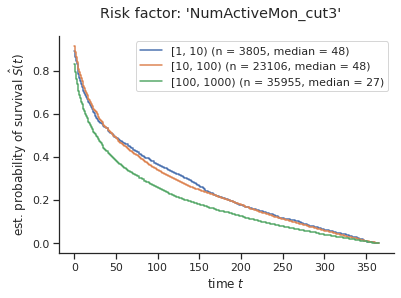

In [1118]:
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

In [1119]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

<AxesSubplot: xlabel='Y', ylabel='NumActiveMon_cut3'>

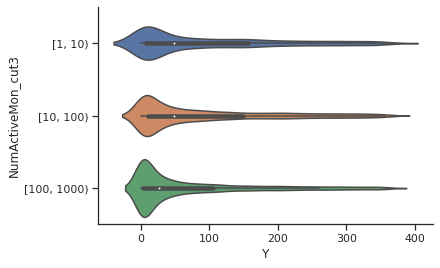

In [1120]:
sns.violinplot(data=df, x="Y", y=column_cut)

---

/tmp/ipykernel_3850516/2561480067.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumActiveMon_cut3b
[0, 90)        25960
[90, 210)      18744
[210, 1000)    18162
dtype: int64

CategoricalDtype(categories=[[0, 90), [90, 210), [210, 1000)], ordered=True)

<AxesSubplot: xlabel='NumActiveMon_cut3b', ylabel='CVE+project'>

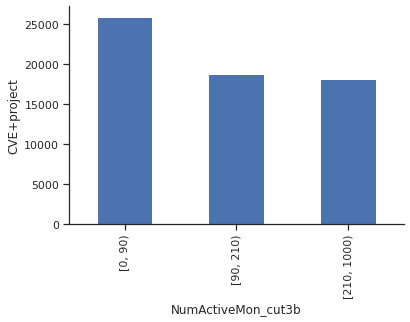

In [1121]:
column_name = 'NumActiveMon'
column_cut = column_name + '_cut3b'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[0,90,210,1000],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

{0: Interval(0, 90, closed='left'), 1: Interval(90, 210, closed='left'), 2: Interval(210, 1000, closed='left')}


all = 62866, selected = 62866, uncensored = 62866
Computing 100 × bootstrap Dxy for 62866 elements...
Computing confidence interval from 100 samples...


{
    "Cohort": 62866,
    "Number of patients": 62866.0,
    "% of cohort": 100.0,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": -0.03842523341655091,
    "bootstrap": {
        "Dxy": -0.038254927618232654,
        "Confidence interval low": -0.0387937834765532,
        "Confidence interval high": -0.03771607175991211,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


Computing descriptive statistics like mean, median, etc....


count  median  min   25%    75%  max       mean  \
NumActiveMon_cut3b                                                    
[0, 90)             25960    48.0    0  10.0  151.0  365  91.893297   
[90, 210)           18744    16.0    0   2.0   72.0  365  56.248666   
[210, 1000)         18162    43.0    0   7.0  139.0  365  86.405792   

                           std      skew  % of cohort  % of selected  \
NumActiveMon_cut3b                                                     
[0, 90)             101.552878  1.079777    41.294181      41.294181   
[90, 210)            84.869035  1.881117    29.815799      29.815799   
[210, 1000)          99.013650  1.173313    28.890020      28.890020   

                    % of patients     IR  
NumActiveMon_cut3b                        
[0, 90)                 41.294181  141.0  
[90, 210)               29.815799   70.0  
[210, 1000)             28.890020  132.0

values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'NumActiveMon_cut3b.svg' and *.pdf


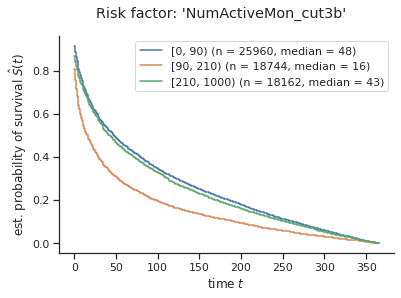

In [1122]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

print(values_names)

f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='Y', ylabel='NumActiveMon_cut3b'>

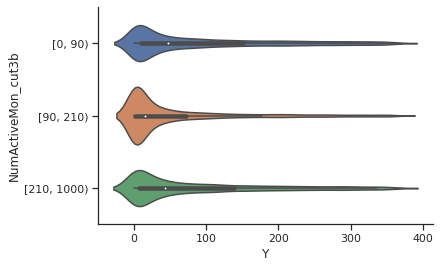

In [1123]:
sns.violinplot(data=df, x="Y", y=column_cut)

In [1124]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

---

---

<AxesSubplot: xlabel='NumActiveMon', ylabel='Y'>

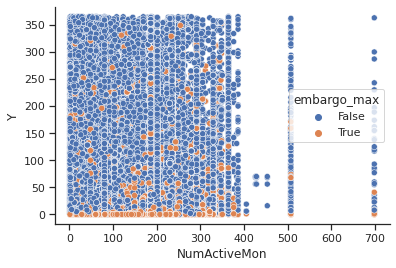

In [1125]:
sns.scatterplot(data=df, x='NumActiveMon', y='Y', hue='embargo_max')

-----
**CommitDateRange \[days]**

In [1126]:
column_name='CommitDateRange [days]'

In [1127]:
df['CommitDateRange [days]'].describe()

count    62866.000000
mean      6738.244584
std       7475.956657
min          0.000000
25%       2382.000000
50%       4486.000000
75%       8247.000000
max      81273.000000
Name: CommitDateRange [days], dtype: float64

<AxesSubplot: ylabel='Count'>

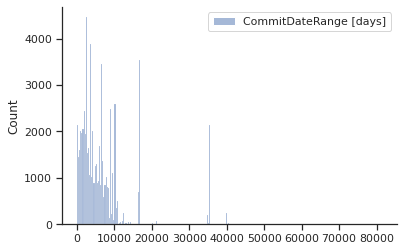

In [1128]:
column_name='CommitDateRange [days]'
sns.histplot(data=df[[column_name]].dropna())

<AxesSubplot: ylabel='Count'>

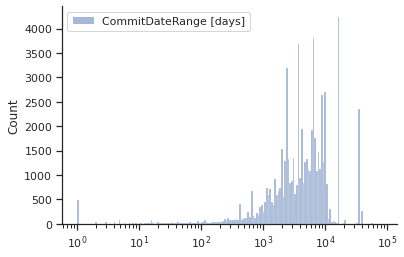

In [1129]:
column_name='CommitDateRange [days]'
sns.histplot(data=df[[column_name]].dropna()+1, log_scale=True)

/tmp/ipykernel_3850516/1020861073.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


CommitDateRange [days] cut6
[0.0, 30.0)           1007
[30.0, 365.0)         1388
[365.0, 1000.0)       3510
[1000.0, 5000.0)     27464
[5000.0, 10000.0)    18531
[10000.0, inf)       10966
dtype: int64

CategoricalDtype(categories=[[0.0, 30.0), [30.0, 365.0), [365.0, 1000.0), [1000.0, 5000.0), [5000.0, 10000.0), [10000.0, inf)], ordered=True)

<AxesSubplot: xlabel='CommitDateRange [days] cut6', ylabel='CVE+project'>

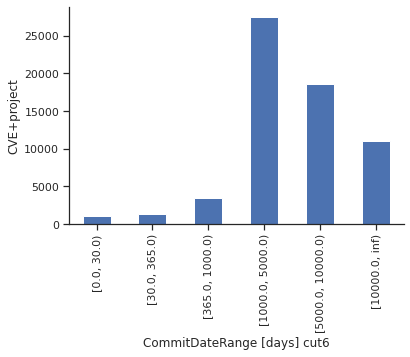

In [1130]:
column_name = 'CommitDateRange [days]'
column_cut = column_name + ' cut6'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[0,30,365,1e3,5e3,1e4,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [1131]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(0.0, 30.0, closed='left'),
 1: Interval(30.0, 365.0, closed='left'),
 2: Interval(365.0, 1000.0, closed='left'),
 3: Interval(1000.0, 5000.0, closed='left'),
 4: Interval(5000.0, 10000.0, closed='left'),
 5: Interval(10000.0, inf, closed='left')}

In [1132]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 62866, selected = 62866, uncensored = 62866
Computing 100 × bootstrap Dxy for 62866 elements...
Computing confidence interval from 100 samples...


{
    "Cohort": 62866,
    "Number of patients": 62866.0,
    "% of cohort": 100.0,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.01681008595722866,
    "bootstrap": {
        "Dxy": 0.016548629983183242,
        "Confidence interval low": 0.016054917951565034,
        "Confidence interval high": 0.01704234201480145,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


Computing descriptive statistics like mean, median, etc....


count  median  min   25%    75%  max        mean  \
CommitDateRange [days] cut6                                                     
[0.0, 30.0)                   1007    34.0    0   6.0  148.0  363   90.203575   
[30.0, 365.0)                 1388    67.0    0  13.0  172.0  365  103.386888   
[365.0, 1000.0)               3510    41.0    0   8.0  144.0  365   85.075783   
[1000.0, 5000.0)             27464    30.0    0   5.0  114.0  365   75.049483   
[5000.0, 10000.0)            18531    27.0    0   3.0  112.0  365   74.093411   
[10000.0, inf)               10966    53.0    0  13.0  157.0  365   95.024713   

                                    std      skew  % of cohort  % of selected  \
CommitDateRange [days] cut6                                                     
[0.0, 30.0)                  106.415141  1.109180     1.601820       1.601820   
[30.0, 365.0)                104.893881  0.885082     2.207871       2.207871   
[365.0, 1000.0)               97.983216  1.172362     5.583304       5.583304   
[1000.0, 5000.0)              94.317654  1.391040    43.686571      43.686571   
[5000.0, 10000.0)             97.125288  1.421645    29.476983      29.476983   
[10000.0, inf)               100.865256  1.035126    17.443451      17.443451   

                             % of patients     IR  
CommitDateRange [days] cut6                        
[0.0, 30.0)                       1.601820  142.0  
[30.0, 365.0)                     2.207871  159.0  
[365.0, 1000.0)                   5.583304  136.0  
[1000.0, 5000.0)                 43.686571  109.0  
[5000.0, 10000.0)                29.476983  109.0  
[10000.0, inf)                   17.443451  144.0

In [1133]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

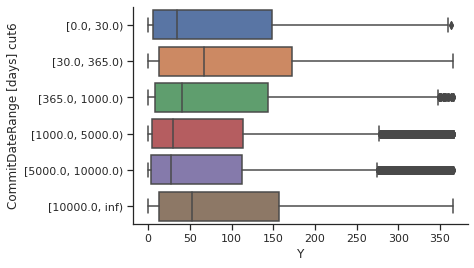

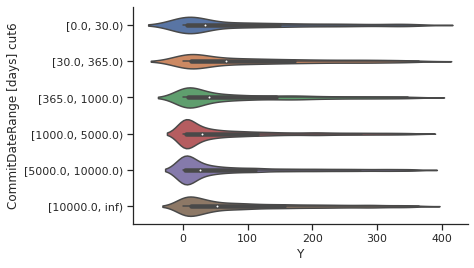

In [1134]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

{0: Interval(0.0, 30.0, closed='left'), 1: Interval(30.0, 365.0, closed='left'), 2: Interval(365.0, 1000.0, closed='left'), 3: Interval(1000.0, 5000.0, closed='left'), 4: Interval(5000.0, 10000.0, closed='left'), 5: Interval(10000.0, inf, closed='left')}
dict_keys([0, 1, 2, 3, 4, 5])
values_list = dict_keys([0, 1, 2, 3, 4, 5])


Saved survival function plot to 'CommitDateRange [days] cut6.svg' and *.pdf


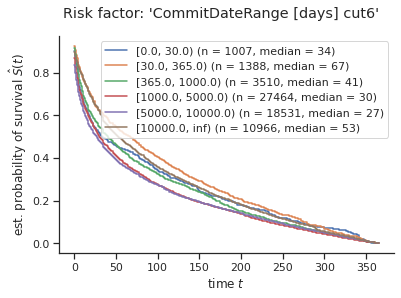

In [1135]:
print(values_names)
print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

---

/tmp/ipykernel_3850516/2909180365.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


CommitDateRange [days] cut3b
[0.0, 3000.0)       21752
[3000.0, 7000.0)    21967
[7000.0, inf)       19147
dtype: int64

CategoricalDtype(categories=[[0.0, 3000.0), [3000.0, 7000.0), [7000.0, inf)], ordered=True)

<AxesSubplot: xlabel='CommitDateRange [days] cut3b', ylabel='CVE+project'>

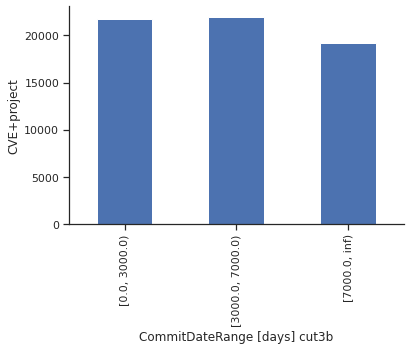

In [1136]:
column_name = 'CommitDateRange [days]'
column_cut = column_name + ' cut3b'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[0,3e3,7e3,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [1137]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

{0: Interval(0.0, 3000.0, closed='left'),
 1: Interval(3000.0, 7000.0, closed='left'),
 2: Interval(7000.0, inf, closed='left')}

all = 62866, selected = 62866, uncensored = 62866
Computing 100 × bootstrap Dxy for 62866 elements...


{
    "Cohort": 62866,
    "Number of patients": 62866.0,
    "% of cohort": 100.0,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": -0.03523376098004993,
    "bootstrap": {
        "Dxy": -0.03537656254801977,
        "Confidence interval low": -0.0358903075437566,
        "Confidence interval high": -0.03486281755228294,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


Computing confidence interval from 100 samples...
Computing descriptive statistics like mean, median, etc....


count  median  min   25%    75%  max       mean  \
CommitDateRange [days] cut3b                                                    
[0.0, 3000.0)                 21752    50.0    0  11.0  152.0  365  92.488967   
[3000.0, 7000.0)              21967    19.0    0   2.0   85.0  365  61.451359   
[7000.0, inf)                 19147    41.0    0   7.0  138.0  365  86.042461   

                                     std      skew  % of cohort  \
CommitDateRange [days] cut3b                                      
[0.0, 3000.0)                 100.806897  1.079600    34.600579   
[3000.0, 7000.0)               88.591268  1.709081    34.942576   
[7000.0, inf)                  99.793525  1.184360    30.456845   

                              % of selected  % of patients     IR  
CommitDateRange [days] cut3b                                       
[0.0, 3000.0)                     34.600579      34.600579  141.0  
[3000.0, 7000.0)                  34.942576      34.942576   83.0  
[7000.0, inf)                     30.456845      30.456845  131.0

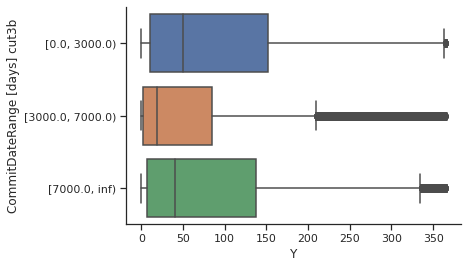

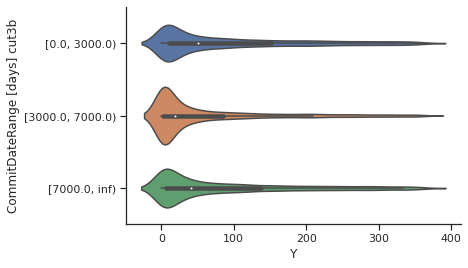

In [1138]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'CommitDateRange [days] cut3b.svg' and *.pdf


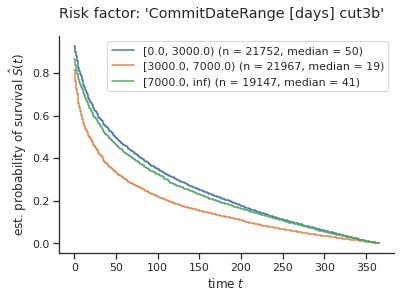

In [1139]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

In [1140]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

---

---

<AxesSubplot: xlabel='CommitDateRange [days]', ylabel='Y'>

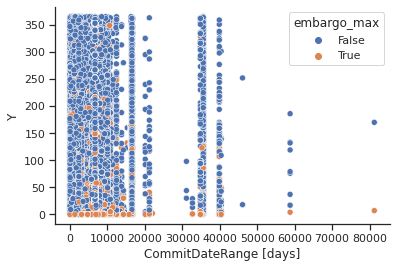

In [1141]:
sns.scatterplot(data=df, x=column_name, y='Y', hue='embargo_max')

<AxesSubplot: xlabel='CommitDateRange [days]', ylabel='Y'>

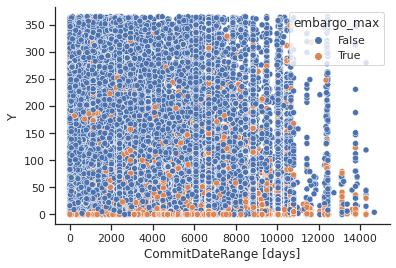

In [1142]:
sns.scatterplot(data=df[df[column_name]<15000], x=column_name, y='Y', hue='embargo_max')

### Popularity: NumStars

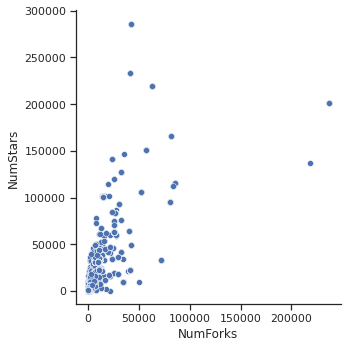

In [1143]:
sns.relplot(df[['NumForks','NumStars']].dropna(),x='NumForks',y='NumStars')
plt.show()

<AxesSubplot: ylabel='Count'>

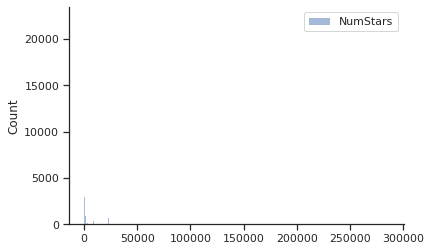

<AxesSubplot: ylabel='Count'>

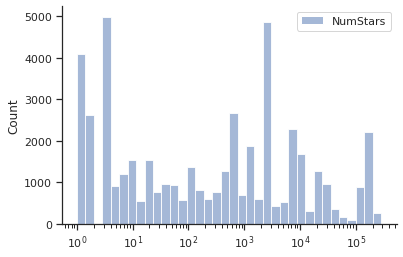

In [1144]:
sns.histplot(data=df[['NumStars']].dropna())
plt.show()
sns.histplot(data=df[['NumStars']].dropna(), log_scale=True)
plt.show()

/tmp/ipykernel_3850516/264017901.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumStars_cut8
[1.0, 2.0)              4093
[2.0, 5.0)              7612
[5.0, 10.0)             2513
[10.0, 100.0)           6522
[100.0, 1000.0)         8028
[1000.0, 10000.0)      11823
[10000.0, 100000.0)     3685
[100000.0, inf)         3370
dtype: int64

CategoricalDtype(categories=[[1.0, 2.0), [2.0, 5.0), [5.0, 10.0), [10.0, 100.0), [100.0, 1000.0), [1000.0, 10000.0), [10000.0, 100000.0), [100000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumStars_cut8', ylabel='CVE+project'>

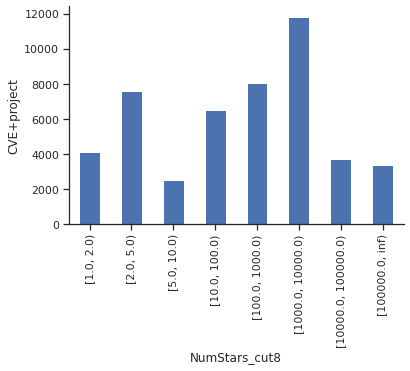

In [1145]:
column_name = 'NumStars'
column_cut = column_name + '_cut8'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,2,5,10,100,1000,10000,100000,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

/tmp/ipykernel_3850516/2881743732.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumStars_cut4
[1.0, 3.0)           6710
[3.0, 100.0)        14030
[100.0, 10000.0)    19851
[10000.0, inf)       7055
dtype: int64

CategoricalDtype(categories=[[1.0, 3.0), [3.0, 100.0), [100.0, 10000.0), [10000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumStars_cut4', ylabel='CVE+project'>

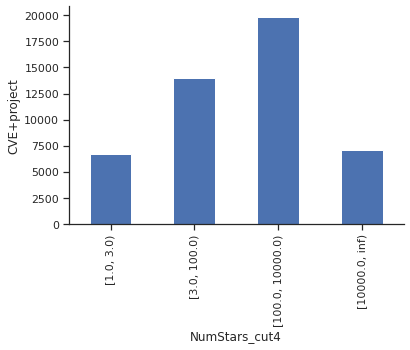

In [1146]:
column_name = 'NumStars'
column_cut = column_name + '_cut4'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,3,100,10000,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

all = 62866, selected = 47646, uncensored = 47646
Computing 100 × bootstrap Dxy for 47646 elements...
Computing confidence interval from 100 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 47646.0,
    "% of cohort": 75.78977507714822,
    "Survival days, median": 40.0,
    "Survival years, median": 0.1095890410958904,
    "Dxy (full)": 0.029234222288123446,
    "bootstrap": {
        "Dxy": 0.029063852646632093,
        "Confidence interval low": 0.02845030271379175,
        "Confidence interval high": 0.029677402579472434,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


count  median  min   25%    75%  max        mean  \
NumStars_cut4                                                        
[1.0, 3.0)         6710    41.0    0   5.0  155.0  365   89.867660   
[3.0, 100.0)      14030    33.0    0   6.0  117.0  365   77.743407   
[100.0, 10000.0)  19851    40.0    0   7.0  129.0  365   82.462193   
[10000.0, inf)     7055    56.0    0  11.0  167.0  365  100.172502   

                         std      skew  % of cohort  % of selected  \
NumStars_cut4                                                        
[1.0, 3.0)        104.342922  1.070487    10.673496      14.083029   
[3.0, 100.0)       96.653150  1.373494    22.317310      29.446333   
[100.0, 10000.0)   95.534515  1.237379    31.576687      41.663518   
[10000.0, inf)    106.613640  0.955192    11.222282      14.807119   

                  % of patients     IR  
NumStars_cut4                           
[1.0, 3.0)            14.083029  150.0  
[3.0, 100.0)          29.446333  111.0  
[100.0, 10000.0)      41.663518  122.0  
[10000.0, inf)        14.807119  156.0

values_list = dict_keys([0, 1, 2, 3])


Saved survival function plot to 'NumStars_cut4.svg' and *.pdf


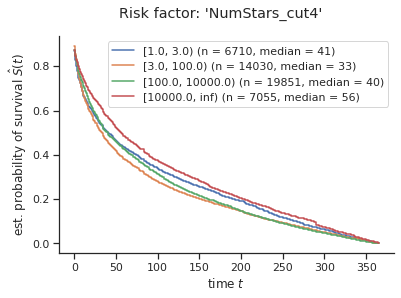

In [1147]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

In [1148]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

<AxesSubplot: xlabel='Y', ylabel='NumStars_cut4'>

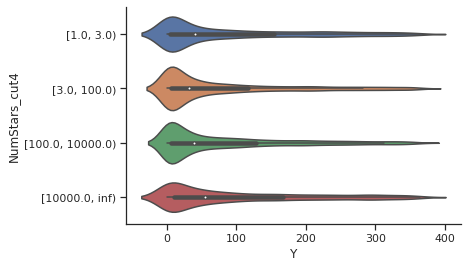

In [1149]:
sns.violinplot(data=df, x="Y", y=column_cut)

In [1150]:
df_mask = df['NumStars'] < 10000
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

#plot_survival_function(params, ddf, condition_names=values_names)

all = 62866, selected = 40591, uncensored = 40591
Computing 100 × bootstrap Dxy for 40591 elements...


{
    "Cohort": 62866,
    "Number of patients": 40591.0,
    "% of cohort": 64.56749276238348,
    "Survival days, median": 37.0,
    "Survival years, median": 0.10136986301369863,
    "Dxy (full)": 0.007114142400958423,
    "bootstrap": {
        "Dxy": 0.007448903051197996,
        "Confidence interval low": 0.006826917614139186,
        "Confidence interval high": 0.008070888488256807,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


Computing confidence interval from 100 samples...
Computing descriptive statistics like mean, median, etc....


count  median  min  25%    75%  max       mean         std  \
NumStars_cut4                                                                  
[1.0, 3.0)         6710    41.0    0  5.0  155.0  365  89.867660  104.342922   
[3.0, 100.0)      14030    33.0    0  6.0  117.0  365  77.743407   96.653150   
[100.0, 10000.0)  19851    40.0    0  7.0  129.0  365  82.462193   95.534515   

                      skew  % of cohort  % of selected  % of patients     IR  
NumStars_cut4                                                                 
[1.0, 3.0)        1.070487    10.673496      16.530758      16.530758  150.0  
[3.0, 100.0)      1.373494    22.317310      34.564312      34.564312  111.0  
[100.0, 10000.0)  1.237379    31.576687      48.904930      48.904930  122.0

In [1151]:
results_summary[f"{column_cut}+NumStars<10000"] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

---

/tmp/ipykernel_3850516/3810480401.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumStars_cut3
[0.0, 100.0)       20740
[100.0, 2500.0)    12058
[2500.0, inf)      14848
dtype: int64

CategoricalDtype(categories=[[0.0, 100.0), [100.0, 2500.0), [2500.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumStars_cut3', ylabel='CVE+project'>

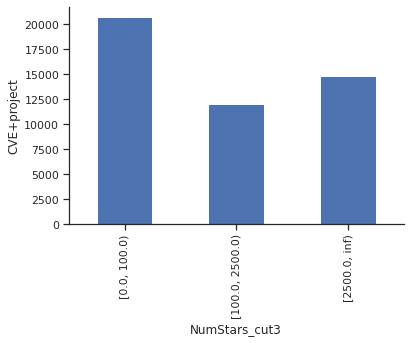

In [1152]:
column_name = 'NumStars'
column_cut = column_name + '_cut3'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[0,100,2500,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

all = 62866, selected = 47646, uncensored = 47646
Computing 100 × bootstrap Dxy for 47646 elements...


{
    "Cohort": 62866,
    "Number of patients": 47646.0,
    "% of cohort": 75.78977507714822,
    "Survival days, median": 40.0,
    "Survival years, median": 0.1095890410958904,
    "Dxy (full)": 0.03545564367278331,
    "bootstrap": {
        "Dxy": 0.035694706026457815,
        "Confidence interval low": 0.03506904538441277,
        "Confidence interval high": 0.03632036666850286,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


Computing confidence interval from 100 samples...
Computing descriptive statistics like mean, median, etc....


count  median  min   25%    75%  max       mean         std  \
NumStars_cut3                                                                  
[0.0, 100.0)     20740    35.0    0  6.00  128.0  365  81.665959   99.365765   
[100.0, 2500.0)  12058    36.0    0  7.00  117.0  365  77.394344   92.250374   
[2500.0, inf)    14848    52.0    0  9.75  159.0  365  94.992794  103.261305   

                     skew  % of cohort  % of selected  % of patients      IR  
NumStars_cut3                                                                 
[0.0, 100.0)     1.268615    32.990806      43.529362      43.529362  122.00  
[100.0, 2500.0)  1.357336    19.180479      25.307476      25.307476  110.00  
[2500.0, inf)    1.016287    23.618490      31.163162      31.163162  149.25

values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'NumStars_cut3.svg' and *.pdf


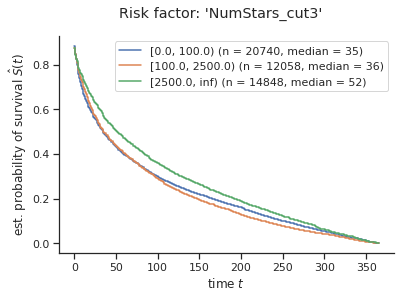

In [1153]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='Y', ylabel='NumStars_cut3'>

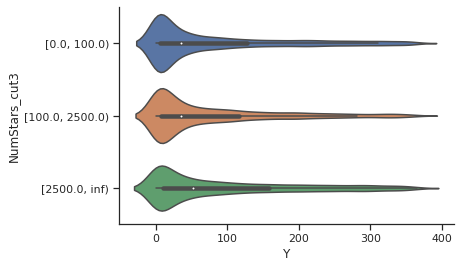

In [1154]:
sns.violinplot(data=df, x="Y", y=column_cut)

In [1155]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

------
------

<AxesSubplot: xlabel='NumStars', ylabel='Y'>

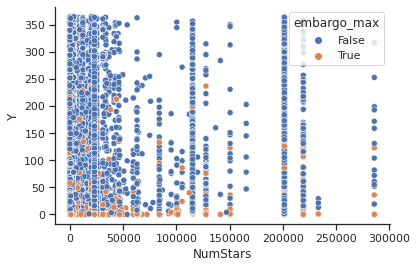

In [1156]:
sns.scatterplot(data=df, x='NumStars', y='Y', hue='embargo_max')

<AxesSubplot: xlabel='NumStars', ylabel='Y'>

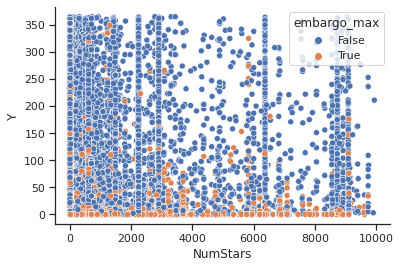

In [1157]:
sns.scatterplot(data=df[df['NumStars'] < 10000], x='NumStars', y='Y', hue='embargo_max')

-----
**NumForks**

In [1158]:
df.columns

Index(['commits', 'commit_cves', 'project_names', 'used_dep_manager',
       'cve_lifespan_commiter_time', 'cve_lifespan_author_time', 'embargo_min',
       'embargo_max', 'lang_Shell', 'other_languages', 'most_common_language',
       'most_common_language_number_of_files', 'programming_paradigm',
       'Programming paradigm', 'compilation_class', 'Compilation class',
       'type_class', 'Type class', 'memory_model', 'Memory model',
       'extended_programming_paradigm', 'Programming paradigm (extended)',
       'cve', 'cvss', 'cwe', 'cvss-vector', 'access.authentication',
       'access.complexity', 'access.vector', 'impact.availability',
       'impact.confidentiality', 'impact.integrity', 'CVSS v2.0 Ratings',
       'CVSS v3.1 Ratings', 'RootFork', 'EarliestCommitDate',
       'LatestCommitDate', 'NumActiveMon', 'NumAuthors', 'NumCore',
       'CommunitySize', 'NumCommits', 'NumBlobs', 'NumFiles', 'NumForks',
       'NumStars', 'E', 'Y', 'NumCore_cut5', 'NumCore_cut2', 'NumCore_

In [1159]:
df[['NumForks','NumStars']].describe()

NumForks       NumStars
count   62859.000000   47646.000000
mean    10552.373709   15912.640327
std     43771.581162   47368.980685
min         0.000000       1.000000
25%         0.000000       5.000000
50%        12.000000     324.000000
75%       827.000000    2902.000000
max    237104.000000  285958.000000

<AxesSubplot: ylabel='Count'>

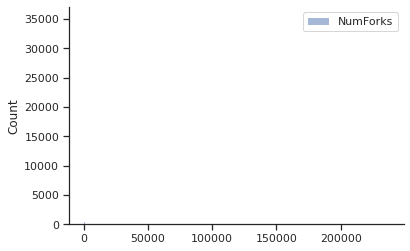

<AxesSubplot: ylabel='Count'>

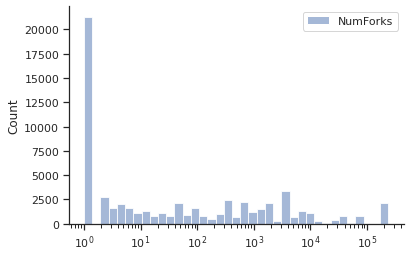

In [1160]:
sns.histplot(data=df[['NumForks']].dropna())
plt.show()
sns.histplot(data=df[['NumForks']].dropna()+1, log_scale=True)
plt.show()

/tmp/ipykernel_3850516/587120883.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumForks_cut5
[0.0, 1.0)        21325
[1.0, 5.0)         6378
[5.0, 10.0)        2701
[10.0, 1000.0)    17396
[1000.0, inf)     15059
dtype: int64

CategoricalDtype(categories=[[0.0, 1.0), [1.0, 5.0), [5.0, 10.0), [10.0, 1000.0), [1000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumForks_cut5', ylabel='CVE+project'>

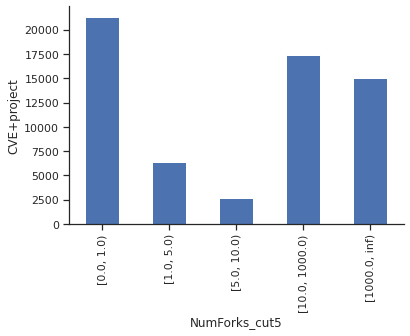

In [1161]:
column_name = 'NumForks'
column_cut = column_name + '_cut5'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[0,1,5,10,1e3,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [1162]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(0.0, 1.0, closed='left'),
 1: Interval(1.0, 5.0, closed='left'),
 2: Interval(5.0, 10.0, closed='left'),
 3: Interval(10.0, 1000.0, closed='left'),
 4: Interval(1000.0, inf, closed='left')}

In [1163]:
df.columns

Index(['commits', 'commit_cves', 'project_names', 'used_dep_manager',
       'cve_lifespan_commiter_time', 'cve_lifespan_author_time', 'embargo_min',
       'embargo_max', 'lang_Shell', 'other_languages', 'most_common_language',
       'most_common_language_number_of_files', 'programming_paradigm',
       'Programming paradigm', 'compilation_class', 'Compilation class',
       'type_class', 'Type class', 'memory_model', 'Memory model',
       'extended_programming_paradigm', 'Programming paradigm (extended)',
       'cve', 'cvss', 'cwe', 'cvss-vector', 'access.authentication',
       'access.complexity', 'access.vector', 'impact.availability',
       'impact.confidentiality', 'impact.integrity', 'CVSS v2.0 Ratings',
       'CVSS v3.1 Ratings', 'RootFork', 'EarliestCommitDate',
       'LatestCommitDate', 'NumActiveMon', 'NumAuthors', 'NumCore',
       'CommunitySize', 'NumCommits', 'NumBlobs', 'NumFiles', 'NumForks',
       'NumStars', 'E', 'Y', 'NumCore_cut5', 'NumCore_cut2', 'NumCore_

In [1164]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 62866, selected = 62859, uncensored = 62859
Computing 100 × bootstrap Dxy for 62859 elements...
Computing confidence interval from 100 samples...


{
    "Cohort": 62866,
    "Number of patients": 62859.0,
    "% of cohort": 99.98886520535743,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.07449118113868725,
    "bootstrap": {
        "Dxy": 0.07435394280777528,
        "Confidence interval low": 0.07379712047867659,
        "Confidence interval high": 0.07491076513687397,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


Computing descriptive statistics like mean, median, etc....


count  median  min   25%    75%  max        mean         std  \
NumForks_cut5                                                                  
[0.0, 1.0)      21325    22.0    0   3.0   98.0  365   67.944431   92.772141   
[1.0, 5.0)       6378    35.0    0   5.0  137.0  365   83.641580  101.069824   
[5.0, 10.0)      2701    59.0    0   9.0  180.0  365  101.888560  106.416104   
[10.0, 1000.0)  17396    33.0    0   6.0  112.0  365   75.088124   92.579305   
[1000.0, inf)   15059    54.0    0  11.0  159.0  365   95.926888  102.650244   

                    skew  % of cohort  % of selected  % of patients     IR  
NumForks_cut5                                                               
[0.0, 1.0)      1.560405    33.921357      33.925134      33.925134   95.0  
[1.0, 5.0)      1.195537    10.145389      10.146518      10.146518  132.0  
[5.0, 10.0)     0.889157     4.296440       4.296919       4.296919  171.0  
[10.0, 1000.0)  1.410060    27.671555      27.674637      27.674637  106.0  
[1000.0, inf)   1.009096    23.954125      23.956792      23.956792  148.0

In [1165]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

<AxesSubplot: xlabel='Y', ylabel='NumForks_cut5'>

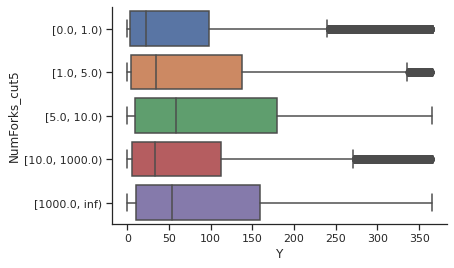

In [1166]:
sns.boxplot(data=df, x="Y", y=column_cut)

<AxesSubplot: xlabel='Y', ylabel='NumForks_cut5'>

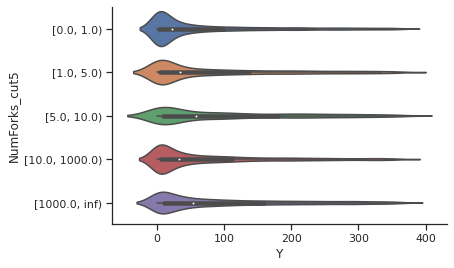

In [1167]:
sns.violinplot(data=df, x="Y", y=column_cut)

{0: Interval(0.0, 1.0, closed='left'), 1: Interval(1.0, 5.0, closed='left'), 2: Interval(5.0, 10.0, closed='left'), 3: Interval(10.0, 1000.0, closed='left'), 4: Interval(1000.0, inf, closed='left')}
dict_keys([0, 1, 2, 3, 4])
values_list = dict_keys([0, 1, 2, 3, 4])


Saved survival function plot to 'NumForks_cut5.svg' and *.pdf


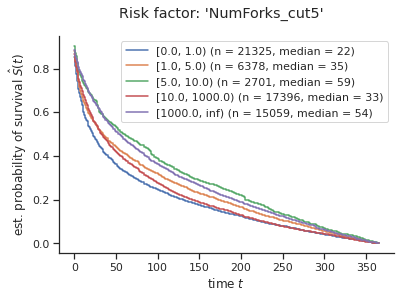

In [1168]:
print(values_names)
print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

---

/tmp/ipykernel_3850516/1708021337.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumForks_cut3
[0.0, 1.0)      21325
[1.0, 300.0)    20096
[300.0, inf)    21438
dtype: int64

CategoricalDtype(categories=[[0.0, 1.0), [1.0, 300.0), [300.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumForks_cut3', ylabel='CVE+project'>

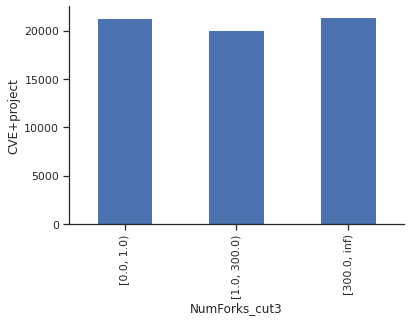

In [1169]:
column_name = 'NumForks'
column_cut = column_name + '_cut3'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[0,1,3e2,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [1170]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

{0: Interval(0.0, 1.0, closed='left'),
 1: Interval(1.0, 300.0, closed='left'),
 2: Interval(300.0, inf, closed='left')}

all = 62866, selected = 62859, uncensored = 62859
Computing 100 × bootstrap Dxy for 62859 elements...
Computing confidence interval from 100 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62859.0,
    "% of cohort": 99.98886520535743,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.07031192490162552,
    "bootstrap": {
        "Dxy": 0.07037639915279723,
        "Confidence interval low": 0.06991522388023229,
        "Confidence interval high": 0.07083757442536216,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


count  median  min  25%    75%  max       mean        std  \
NumForks_cut3                                                              
[0.0, 1.0)     21325    22.0    0  3.0   98.0  365  67.944431  92.772141   
[1.0, 300.0)   20096    35.0    0  6.0  129.0  365  81.930384  98.747959   
[300.0, inf)   21438    48.0    0  9.0  144.0  365  89.233604  99.267788   

                   skew  % of cohort  % of selected  % of patients     IR  
NumForks_cut3                                                              
[0.0, 1.0)     1.560405    33.921357      33.925134      33.925134   95.0  
[1.0, 300.0)   1.250392    31.966405      31.969965      31.969965  123.0  
[300.0, inf)   1.127883    34.101104      34.104901      34.104901  135.0

<AxesSubplot: xlabel='Y', ylabel='NumForks_cut3'>

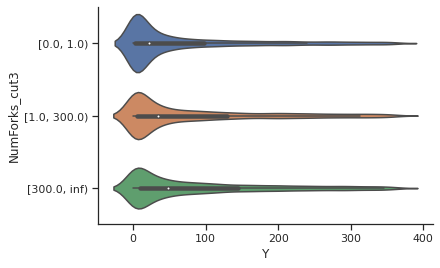

In [1171]:
sns.violinplot(data=df, x="Y", y=column_cut)

{0: Interval(0.0, 1.0, closed='left'), 1: Interval(1.0, 300.0, closed='left'), 2: Interval(300.0, inf, closed='left')}
values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'NumForks_cut3.svg' and *.pdf


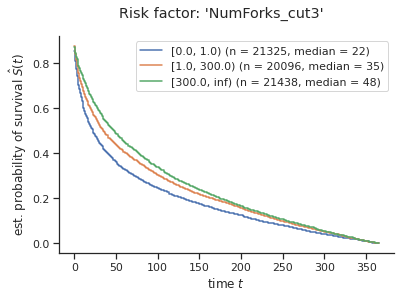

In [1172]:
print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

In [1173]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

---

<AxesSubplot: xlabel='NumForks', ylabel='Y'>

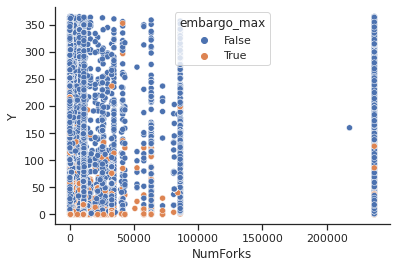

In [1174]:
sns.scatterplot(data=df, x='NumForks', y='Y', hue='embargo_max')

----
**CommunitySize** (shared commits?)

In [1175]:
df['CommunitySize'].describe()

count     62859.000000
mean       6275.887637
std       22270.800159
min           1.000000
25%           1.000000
50%          16.000000
75%         792.000000
max      154323.000000
Name: CommunitySize, dtype: float64

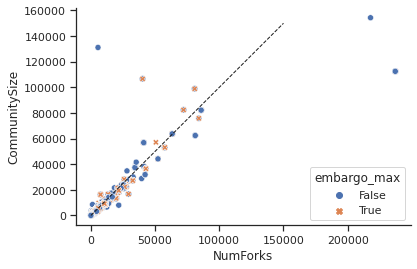

In [1176]:
g = sns.scatterplot(df,x='NumForks',y='CommunitySize',
                    hue='embargo_max', style='embargo_max')
ax = plt.gca()
ax.plot([0,150000], [0,150000], linestyle='--', color='k', lw=1, scalex=False, scaley=False)

<AxesSubplot: ylabel='Count'>

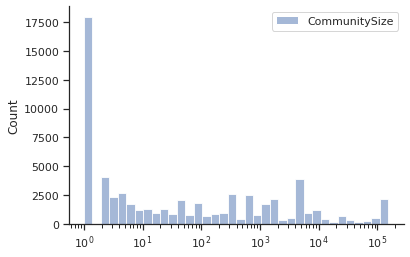

In [1177]:
#sns.histplot(data=df[['CommunitySize']].dropna())
#plt.show()
sns.histplot(data=df[['CommunitySize']].dropna(), log_scale=True)
plt.show()

/tmp/ipykernel_3850516/444363897.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


CommunitySize_cut5
[1.0, 2.0)        17977
[2.0, 6.0)         9092
[6.0, 10.0)        2499
[10.0, 1000.0)    17827
[1000.0, inf)     15464
dtype: int64

CategoricalDtype(categories=[[1.0, 2.0), [2.0, 6.0), [6.0, 10.0), [10.0, 1000.0), [1000.0, inf)], ordered=True)

<AxesSubplot: xlabel='CommunitySize_cut5', ylabel='CVE+project'>

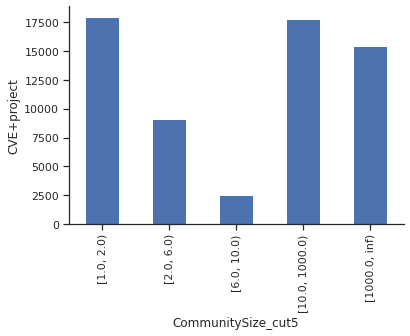

In [1178]:
column_name = 'CommunitySize'
column_cut = column_name + '_cut5'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,2,6,10,1e3,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [1179]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(1.0, 2.0, closed='left'),
 1: Interval(2.0, 6.0, closed='left'),
 2: Interval(6.0, 10.0, closed='left'),
 3: Interval(10.0, 1000.0, closed='left'),
 4: Interval(1000.0, inf, closed='left')}

In [1180]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 62866, selected = 62859, uncensored = 62859
Computing 100 × bootstrap Dxy for 62859 elements...
Computing confidence interval from 100 samples...


{
    "Cohort": 62866,
    "Number of patients": 62859.0,
    "% of cohort": 99.98886520535743,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.06271680733969465,
    "bootstrap": {
        "Dxy": 0.06282151495592143,
        "Confidence interval low": 0.06227225930112341,
        "Confidence interval high": 0.06337077061071945,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


Computing descriptive statistics like mean, median, etc....


count  median  min   25%    75%  max       mean  \
CommunitySize_cut5                                                    
[1.0, 2.0)          17977    23.0    0   4.0  102.0  365  69.528342   
[2.0, 6.0)           9092    31.0    0   4.0  125.0  365  79.106687   
[6.0, 10.0)          2499    55.0    0   6.0  168.0  365  96.670668   
[10.0, 1000.0)      17827    33.0    0   6.0  112.0  365  75.599484   
[1000.0, inf)       15464    50.0    0  10.0  156.0  365  93.762093   

                           std      skew  % of cohort  % of selected  \
CommunitySize_cut5                                                     
[1.0, 2.0)           94.128766  1.523910    28.595743      28.598928   
[2.0, 6.0)           98.236698  1.288224    14.462508      14.464118   
[6.0, 10.0)         104.783829  0.956454     3.975122       3.975564   
[10.0, 1000.0)       92.727608  1.407174    28.357141      28.360298   
[1000.0, inf)       102.377254  1.037739    24.598352      24.601091   

                    % of patients     IR  
CommunitySize_cut5                        
[1.0, 2.0)              28.598928   98.0  
[2.0, 6.0)              14.464118  121.0  
[6.0, 10.0)              3.975564  162.0  
[10.0, 1000.0)          28.360298  106.0  
[1000.0, inf)           24.601091  146.0

In [1181]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

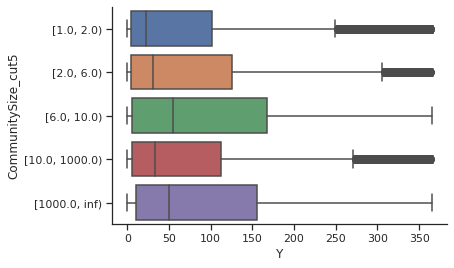

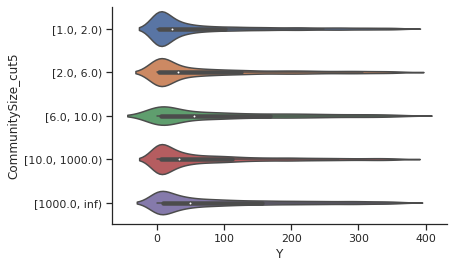

In [1182]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

values_list = dict_keys([0, 1, 2, 3, 4])


Saved survival function plot to 'CommunitySize_cut5.svg' and *.pdf


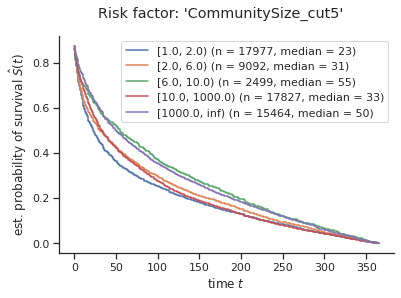

In [1183]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

---

/tmp/ipykernel_3850516/3581446100.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


CommunitySize_cut3
[1.0, 2.0)      17977
[2.0, 100.0)    20895
[100.0, inf)    23987
dtype: int64

CategoricalDtype(categories=[[1.0, 2.0), [2.0, 100.0), [100.0, inf)], ordered=True)

<AxesSubplot: xlabel='CommunitySize_cut3', ylabel='CVE+project'>

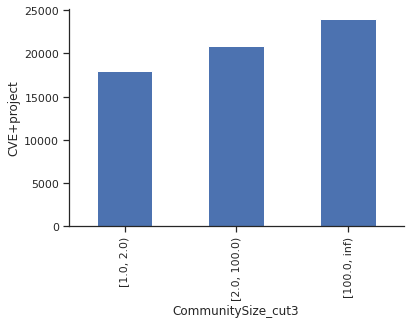

In [1184]:
column_name = 'CommunitySize'
column_cut = column_name + '_cut3'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,2,1e2,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [1185]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)
print(groups[['count','% of cohort','median']].style.format(precision=2).to_latex(siunitx=True))

{0: Interval(1.0, 2.0, closed='left'),
 1: Interval(2.0, 100.0, closed='left'),
 2: Interval(100.0, inf, closed='left')}

all = 62866, selected = 62859, uncensored = 62859
Computing 100 × bootstrap Dxy for 62859 elements...


{
    "Cohort": 62866,
    "Number of patients": 62859.0,
    "% of cohort": 99.98886520535743,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.058729392759663934,
    "bootstrap": {
        "Dxy": 0.05843250921567234,
        "Confidence interval low": 0.057903051822881524,
        "Confidence interval high": 0.05896196660846316,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


Computing confidence interval from 100 samples...
Computing descriptive statistics like mean, median, etc....


count  median  min  25%    75%  max       mean        std  \
CommunitySize_cut3                                                              
[1.0, 2.0)          17977    23.0    0  4.0  102.0  365  69.528342  94.128766   
[2.0, 100.0)        20895    33.0    0  5.0  123.0  365  79.012874  97.124745   
[100.0, inf)        23987    45.0    0  8.0  141.0  365  87.859799  99.166855   

                        skew  % of cohort  % of selected  % of patients     IR  
CommunitySize_cut3                                                              
[1.0, 2.0)          1.523910    28.595743      28.598928      28.598928   98.0  
[2.0, 100.0)        1.307959    33.237362      33.241063      33.241063  118.0  
[100.0, inf)        1.149639    38.155760      38.160009      38.160009  133.0

\begin{tabular}{lSSS}
{} & {count} & {% of cohort} & {median} \\
{CommunitySize_cut3} & {} & {} & {} \\
[1.0, 2.0) & 17977 & 28.60 & 23.00 \\
[2.0, 100.0) & 20895 & 33.24 & 33.00 \\
[100.0, inf) & 23987 & 38.16 & 45.00 \\
\end{tabular}



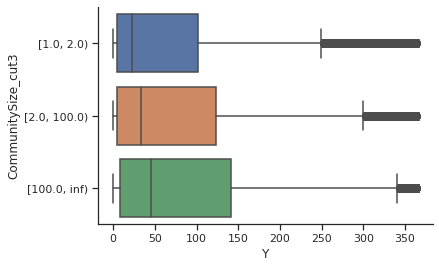

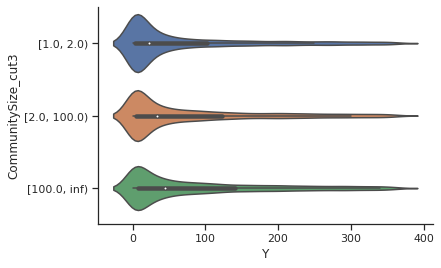

In [1186]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'CommunitySize_cut3.svg' and *.pdf


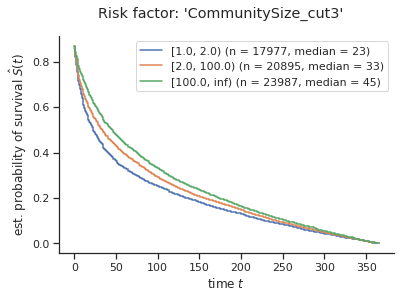

In [1187]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

In [1188]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

---
---

<AxesSubplot: xlabel='CommunitySize', ylabel='Y'>

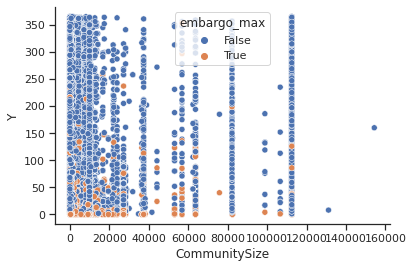

In [1189]:
sns.scatterplot(data=df, x='CommunitySize', y='Y', hue='embargo_max')

### NumFiles and NumBlobs

In [1190]:
column_name='NumFiles'

In [1191]:
df['NumFiles'].describe()

count    6.286600e+04
mean     5.297661e+05
std      1.647684e+06
min      1.000000e+00
25%      1.562250e+03
50%      4.764100e+04
75%      1.982530e+05
max      4.307279e+07
Name: NumFiles, dtype: float64

<AxesSubplot: xlabel='Y'>

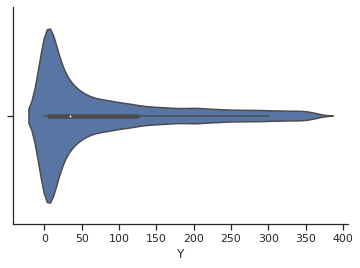

In [1192]:
sns.violinplot(data=df[['Y','NumFiles']], x="Y")

<AxesSubplot: ylabel='Count'>

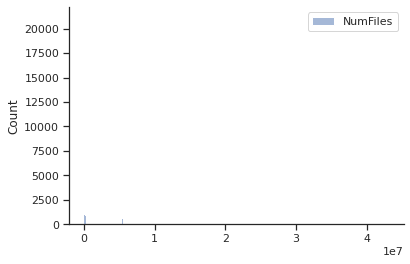

<AxesSubplot: ylabel='Count'>

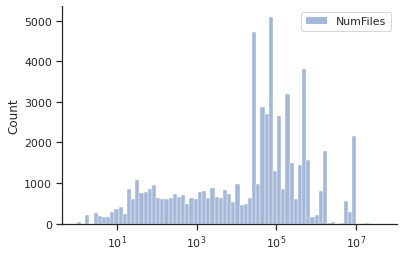

In [1193]:
sns.histplot(data=df[[column_name]].dropna())
plt.show()
sns.histplot(data=df[[column_name]].dropna(), log_scale=True)
plt.show()

/tmp/ipykernel_3850516/623440437.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumFiles_cut5
[1.0, 50.0)              5713
[50.0, 1000.0)           8692
[1000.0, 100000.0)      26557
[100000.0, 500000.0)    11051
[500000.0, inf)         10853
dtype: int64

CategoricalDtype(categories=[[1.0, 50.0), [50.0, 1000.0), [1000.0, 100000.0), [100000.0, 500000.0), [500000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumFiles_cut5', ylabel='CVE+project'>

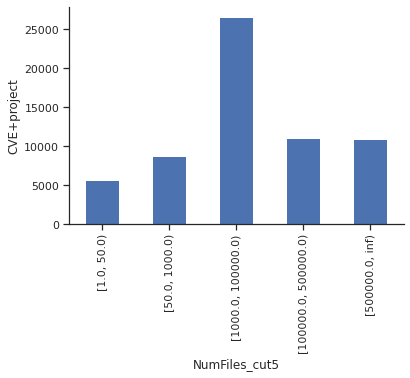

In [1194]:
column_name='NumFiles'
column_cut = column_name + '_cut5'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,50,1e3,1e5,5e5,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [1195]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(1.0, 50.0, closed='left'),
 1: Interval(50.0, 1000.0, closed='left'),
 2: Interval(1000.0, 100000.0, closed='left'),
 3: Interval(100000.0, 500000.0, closed='left'),
 4: Interval(500000.0, inf, closed='left')}

In [1196]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 62866, selected = 62866, uncensored = 62866
Computing 100 × bootstrap Dxy for 62866 elements...
Computing confidence interval from 100 samples...


{
    "Cohort": 62866,
    "Number of patients": 62866.0,
    "% of cohort": 100.0,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.05756860894540261,
    "bootstrap": {
        "Dxy": 0.05754541308611669,
        "Confidence interval low": 0.05703702193242002,
        "Confidence interval high": 0.05805380423981335,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


Computing descriptive statistics like mean, median, etc....


count  median  min   25%    75%  max       mean  \
NumFiles_cut5                                                           
[1.0, 50.0)            5713    25.0    0   4.0  111.0  365  74.014003   
[50.0, 1000.0)         8692    21.0    0   3.0   87.0  365  63.417855   
[1000.0, 100000.0)    26557    35.0    0   5.0  135.0  365  82.666830   
[100000.0, 500000.0)  11051    31.0    0   6.0  100.0  365  69.184961   
[500000.0, inf)       10853    57.0    0  13.0  166.0  365  99.065788   

                             std      skew  % of cohort  % of selected  \
NumFiles_cut5                                                            
[1.0, 50.0)            96.872658  1.437662     9.087583       9.087583   
[50.0, 1000.0)         88.988601  1.692396    13.826234      13.826234   
[1000.0, 100000.0)     99.288232  1.213338    42.243820      42.243820   
[100000.0, 500000.0)   87.975987  1.571138    17.578659      17.578659   
[500000.0, inf)       104.270452  0.963760    17.263704      17.263704   

                      % of patients     IR  
NumFiles_cut5                               
[1.0, 50.0)                9.087583  107.0  
[50.0, 1000.0)            13.826234   84.0  
[1000.0, 100000.0)        42.243820  130.0  
[100000.0, 500000.0)      17.578659   94.0  
[500000.0, inf)           17.263704  153.0

In [1197]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

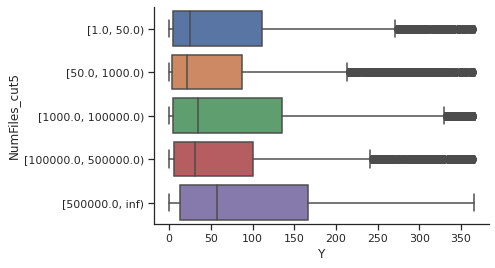

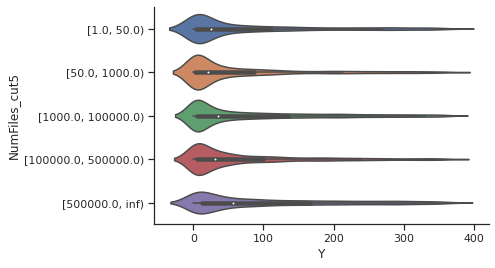

In [1198]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

values_list = dict_keys([0, 1, 2, 3, 4])


Saved survival function plot to 'NumFiles_cut5.svg' and *.pdf


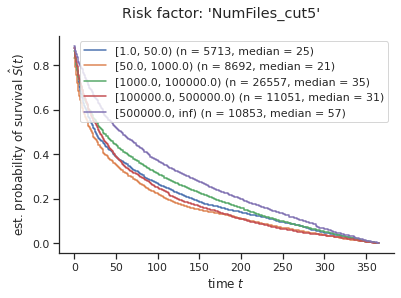

In [1199]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

---

/tmp/ipykernel_3850516/1403738766.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumFiles_cut3
[1.0, 10000.0)         21171
[10000.0, 100000.0)    19791
[100000.0, inf)        21904
dtype: int64

CategoricalDtype(categories=[[1.0, 10000.0), [10000.0, 100000.0), [100000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumFiles_cut3', ylabel='CVE+project'>

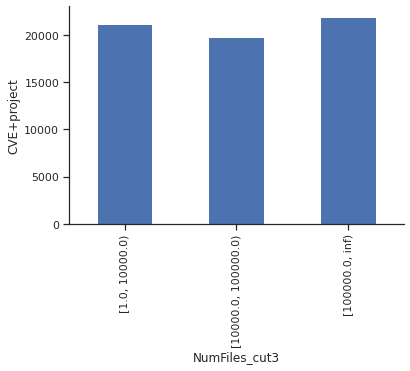

In [1200]:
column_name='NumFiles'
column_cut = column_name + '_cut3'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,1e4,1e5,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [1201]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

{0: Interval(1.0, 10000.0, closed='left'),
 1: Interval(10000.0, 100000.0, closed='left'),
 2: Interval(100000.0, inf, closed='left')}

all = 62866, selected = 62866, uncensored = 62866
Computing 100 × bootstrap Dxy for 62866 elements...
Computing confidence interval from 100 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62866.0,
    "% of cohort": 100.0,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.053289380007989884,
    "bootstrap": {
        "Dxy": 0.05388599863019847,
        "Confidence interval low": 0.05337994411117295,
        "Confidence interval high": 0.05439205314922398,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


count  median  min  25%    75%  max       mean  \
NumFiles_cut3                                                         
[1.0, 10000.0)       21171    25.0    0  3.0  103.0  365  69.702895   
[10000.0, 100000.0)  19791    37.0    0  7.0  142.0  365  85.582992   
[100000.0, inf)      21904    41.0    0  8.0  131.0  365  83.990321   

                            std      skew  % of cohort  % of selected  \
NumFiles_cut3                                                           
[1.0, 10000.0)        92.850618  1.513040    33.676391      33.676391   
[10000.0, 100000.0)  100.938105  1.163220    31.481246      31.481246   
[100000.0, inf)       97.543195  1.240398    34.842363      34.842363   

                     % of patients     IR  
NumFiles_cut3                              
[1.0, 10000.0)           33.676391  100.0  
[10000.0, 100000.0)      31.481246  135.0  
[100000.0, inf)          34.842363  123.0

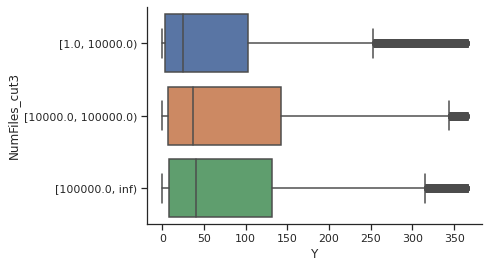

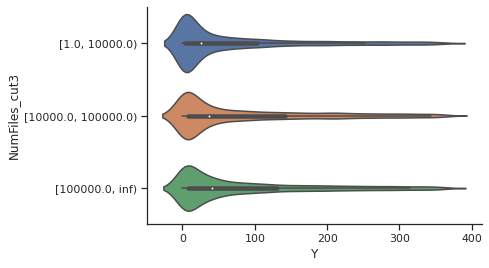

In [1202]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'NumFiles_cut3.svg' and *.pdf


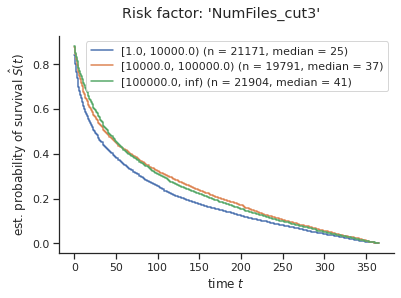

In [1203]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

In [1204]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

---
cut2

/tmp/ipykernel_3850516/2973855629.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumFiles_cut2.v1
[1.0, 50000.0)    32005
[50000.0, inf)    30861
dtype: int64

CategoricalDtype(categories=[[1.0, 50000.0), [50000.0, inf)], ordered=True)

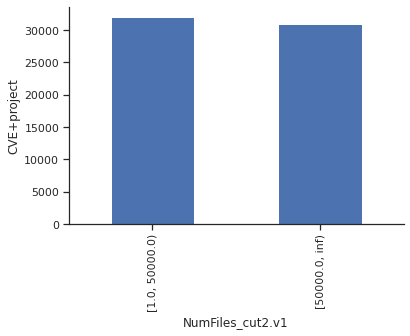

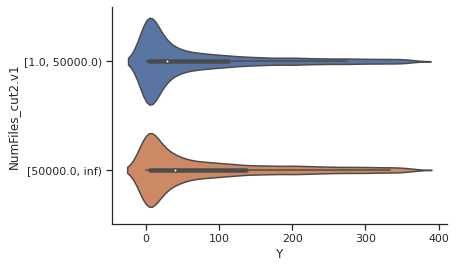

In [1205]:
column_name='NumFiles'
column_cut = column_name + '_cut2.v1'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,5e4,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')
plt.show()

sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

{0: Interval(1.0, 50000.0, closed='left'),
 1: Interval(50000.0, inf, closed='left')}

all = 62866, selected = 62866, uncensored = 62866
Computing 100 × bootstrap Dxy for 62866 elements...
Computing confidence interval from 100 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62866.0,
    "% of cohort": 100.0,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.03123148898458905,
    "bootstrap": {
        "Dxy": 0.031053064115190984,
        "Confidence interval low": 0.030551884013958832,
        "Confidence interval high": 0.03155424421642314,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


count  median  min  25%    75%  max       mean        std  \
NumFiles_cut2.v1                                                              
[1.0, 50000.0)    32005    29.0    0  5.0  113.0  365  74.838713  95.233775   
[50000.0, inf)    30861    40.0    0  6.0  137.0  365  84.701209  99.245100   

                      skew  % of cohort  % of selected  % of patients     IR  
NumFiles_cut2.v1                                                              
[1.0, 50000.0)    1.406420    50.909872      50.909872      50.909872  108.0  
[50000.0, inf)    1.195841    49.090128      49.090128      49.090128  131.0

values_list = dict_keys([0, 1])


Saved survival function plot to 'NumFiles_cut2.v1.svg' and *.pdf


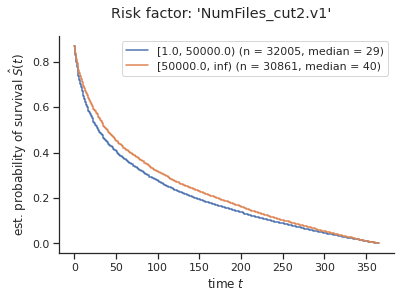

In [1206]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

In [1207]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

/tmp/ipykernel_3850516/2389929770.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumFiles_cut2.v2
[1.0, 1000.0)    14405
[1000.0, inf)    48461
dtype: int64

CategoricalDtype(categories=[[1.0, 1000.0), [1000.0, inf)], ordered=True)

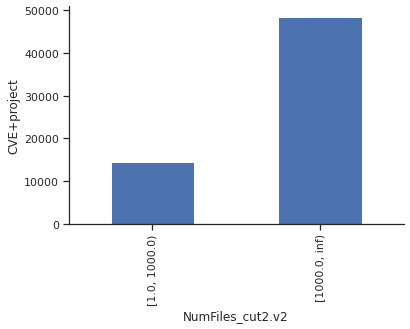

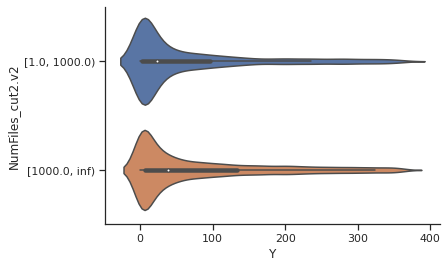

In [1208]:
column_name='NumFiles'
column_cut = column_name + '_cut2.v2'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,1e3,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')
plt.show()

sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

{0: Interval(1.0, 1000.0, closed='left'),
 1: Interval(1000.0, inf, closed='left')}

all = 62866, selected = 62866, uncensored = 62866
Computing 100 × bootstrap Dxy for 62866 elements...


{
    "Cohort": 62866,
    "Number of patients": 62866.0,
    "% of cohort": 100.0,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.03904701191412907,
    "bootstrap": {
        "Dxy": 0.0389154093078138,
        "Confidence interval low": 0.03853028589336798,
        "Confidence interval high": 0.03930053272225962,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


Computing confidence interval from 100 samples...
Computing descriptive statistics like mean, median, etc....


count  median  min  25%    75%  max       mean        std  \
NumFiles_cut2.v2                                                              
[1.0, 1000.0)     14405    23.0    0  3.0   96.0  365  67.620271  92.338414   
[1000.0, inf)     48461    38.0    0  7.0  134.0  365  83.265038  98.504507   

                      skew  % of cohort  % of selected  % of patients     IR  
NumFiles_cut2.v2                                                              
[1.0, 1000.0)     1.586295    22.913817      22.913817      22.913817   93.0  
[1000.0, inf)     1.224883    77.086183      77.086183      77.086183  127.0

values_list = dict_keys([0, 1])


Saved survival function plot to 'NumFiles_cut2.v2.svg' and *.pdf


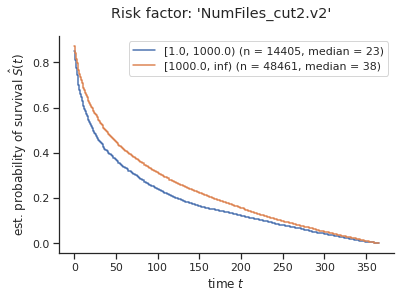

In [1209]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

In [1210]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

/tmp/ipykernel_3850516/2846286176.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumFiles_cut2
[1.0, 10000.0)    21171
[10000.0, inf)    41695
dtype: int64

CategoricalDtype(categories=[[1.0, 10000.0), [10000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumFiles_cut2', ylabel='CVE+project'>

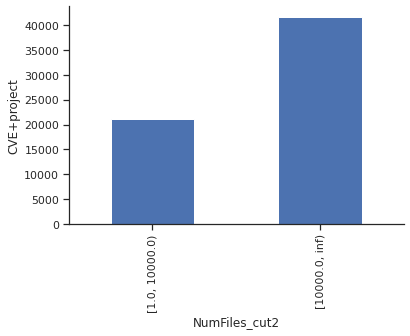

<AxesSubplot: xlabel='Y', ylabel='NumFiles_cut2'>

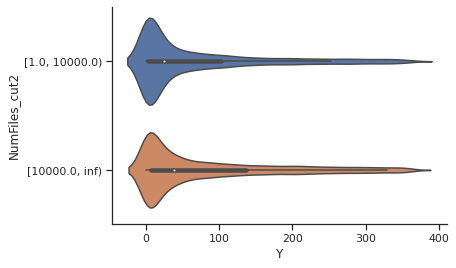

In [1211]:
column_name='NumFiles'
column_cut = column_name + '_cut2'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,1e4,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')
plt.show()

sns.violinplot(data=df, x="Y", y=column_cut)
plt.show()

{0: Interval(1.0, 10000.0, closed='left'),
 1: Interval(10000.0, inf, closed='left')}

all = 62866, selected = 62866, uncensored = 62866
Computing 100 × bootstrap Dxy for 62866 elements...


{
    "Cohort": 62866,
    "Number of patients": 62866.0,
    "% of cohort": 100.0,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.050378416991346375,
    "bootstrap": {
        "Dxy": 0.050349789063839696,
        "Confidence interval low": 0.04997124046013333,
        "Confidence interval high": 0.050728337667546065,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


Computing confidence interval from 100 samples...
Computing descriptive statistics like mean, median, etc....


count  median  min  25%    75%  max       mean        std  \
NumFiles_cut2                                                               
[1.0, 10000.0)  21171    25.0    0  3.0  103.0  365  69.702895  92.850618   
[10000.0, inf)  41695    39.0    0  7.0  136.5  365  84.746301  99.171114   

                    skew  % of cohort  % of selected  % of patients     IR  
NumFiles_cut2                                                               
[1.0, 10000.0)  1.513040    33.676391      33.676391      33.676391  100.0  
[10000.0, inf)  1.202977    66.323609      66.323609      66.323609  129.5

values_list = dict_keys([0, 1])


Saved survival function plot to 'NumFiles_cut2.svg' and *.pdf


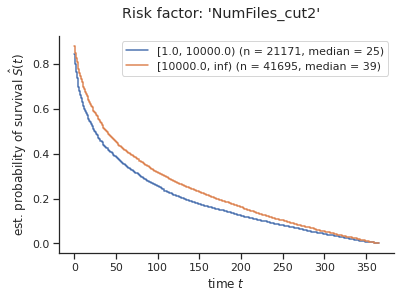

In [1212]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

In [1213]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

---
Scatterplots

<AxesSubplot: xlabel='NumFiles', ylabel='Y'>

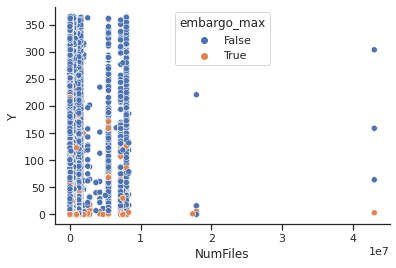

In [1214]:
sns.scatterplot(data=df, x=column_name, y='Y', hue='embargo_max')

<AxesSubplot: xlabel='NumFiles', ylabel='Y'>

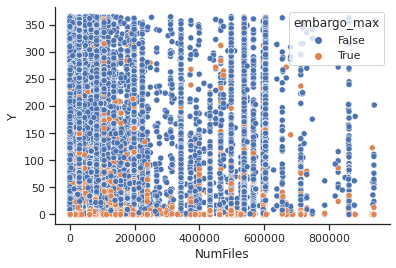

In [1215]:
sns.scatterplot(data=df[df['NumFiles']<1e6], x=column_name, y='Y', hue='embargo_max')

----
**NumBlobs**

In [1216]:
column_name='NumBlobs'

<AxesSubplot: xlabel='NumFiles', ylabel='NumBlobs'>

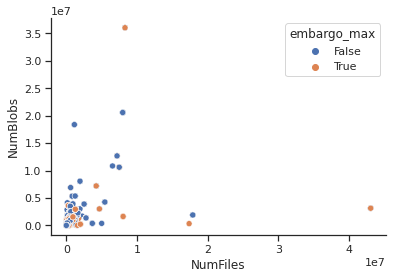

[None, None]

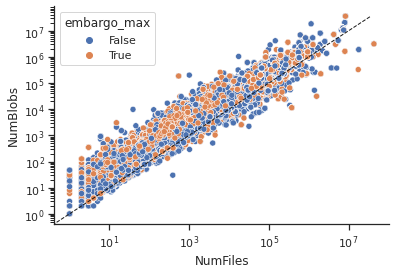

In [1217]:
sns.scatterplot(data=df, x='NumFiles', y='NumBlobs', hue='embargo_max')
plt.show()
splot = sns.scatterplot(data=df, x='NumFiles', y='NumBlobs', hue='embargo_max')
ax = plt.gca()
ax.plot([0,3.5e7], [0,3.5e7], linestyle='--', color='k', lw=1, scalex=False, scaley=False)
splot.set(xscale="log",yscale="log")
plt.show()
#sns.scatterplot(data=df[df['NumFiles']<1e6], x='NumFiles', y='NumBlobs', hue='embargo_max')
#plt.show()

In [1218]:
mask = df['NumBlobs']<df['NumFiles']
print(f"{mask.sum()} CVE+project has NumBlobs < NumFiles ??? (heavy use of submodules?)")
print(f"{df['project_names'][mask].nunique(dropna=True)} projects")
df['project_names'][mask].drop_duplicates()

3855 CVE+project has NumBlobs < NumFiles ??? (heavy use of submodules?)
756 projects


174                             freebsd_freebsd
194                       ztemt_NX606J_O_kernel
389                                SVoxel_R7800
390                                SVoxel_R9000
393      ThunderStorms21th_Galaxy-S7-Pie-kernel
                          ...                  
95656                     ualbertalib_discovery
97467                             zabbix_zabbix
97514                      wireghoul_sploit-dev
97653                  yasirmcs_docker-workshop
97677                         zefredz_claroline
Name: project_names, Length: 756, dtype: object

In [1219]:
df[['Y','NumFiles','NumBlobs']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62866 entries, 43 to 97745
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Y         62866 non-null  int64
 1   NumFiles  62866 non-null  Int64
 2   NumBlobs  62866 non-null  Int64
dtypes: Int64(2), int64(1)
memory usage: 2.0 MB


<AxesSubplot: ylabel='Count'>

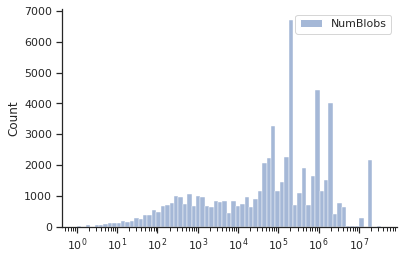

In [1220]:
#sns.histplot(data=df[[column_name]].dropna())
#plt.show()
sns.histplot(data=df[[column_name]].dropna(), log_scale=True)
plt.show()

/tmp/ipykernel_3850516/2835790279.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumBlobs_cut5
[1.0, 500.0)              8016
[500.0, 10000.0)          9352
[10000.0, 100000.0)      13180
[100000.0, 1000000.0)    18301
[1000000.0, inf)         14017
dtype: int64

CategoricalDtype(categories=[[1.0, 500.0), [500.0, 10000.0), [10000.0, 100000.0), [100000.0, 1000000.0), [1000000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumBlobs_cut5', ylabel='CVE+project'>

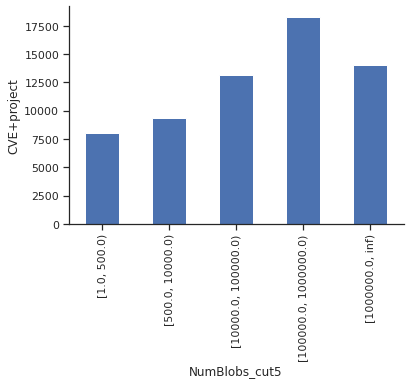

In [1221]:
column_cut = column_name + '_cut5'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,5e2,1e4,1e5,1e6,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [1222]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(1.0, 500.0, closed='left'),
 1: Interval(500.0, 10000.0, closed='left'),
 2: Interval(10000.0, 100000.0, closed='left'),
 3: Interval(100000.0, 1000000.0, closed='left'),
 4: Interval(1000000.0, inf, closed='left')}

In [1223]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 62866, selected = 62866, uncensored = 62866
Computing 100 × bootstrap Dxy for 62866 elements...
Computing confidence interval from 100 samples...
Computing descriptive statistics like mean, median, etc....


{
    "Cohort": 62866,
    "Number of patients": 62866.0,
    "% of cohort": 100.0,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": 0.021549741535667577,
    "bootstrap": {
        "Dxy": 0.021259507124385922,
        "Confidence interval low": 0.020732841727262412,
        "Confidence interval high": 0.021786172521509432,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


count  median  min   25%    75%  max       mean  \
NumBlobs_cut5                                                            
[1.0, 500.0)            8016    25.0    0   5.0  100.0  365  70.364147   
[500.0, 10000.0)        9352    28.0    0   3.0  111.0  365  73.322712   
[10000.0, 100000.0)    13180    55.5    0  10.0  163.0  365  96.269954   
[100000.0, 1000000.0)  18301    25.0    0   4.0  102.0  365  70.397956   
[1000000.0, inf)       14017    43.0    0  10.0  135.0  365  85.769637   

                              std      skew  % of cohort  % of selected  \
NumBlobs_cut5                                                             
[1.0, 500.0)            93.736842  1.541128    12.750931      12.750931   
[500.0, 10000.0)        94.787163  1.409735    14.876086      14.876086   
[10000.0, 100000.0)    102.390624  0.975335    20.965228      20.965228   
[100000.0, 1000000.0)   94.631550  1.514958    29.111125      29.111125   
[1000000.0, inf)        97.215532  1.197970    22.296631      22.296631   

                       % of patients     IR  
NumBlobs_cut5                                
[1.0, 500.0)               12.750931   95.0  
[500.0, 10000.0)           14.876086  108.0  
[10000.0, 100000.0)        20.965228  153.0  
[100000.0, 1000000.0)      29.111125   98.0  
[1000000.0, inf)           22.296631  125.0

In [1224]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

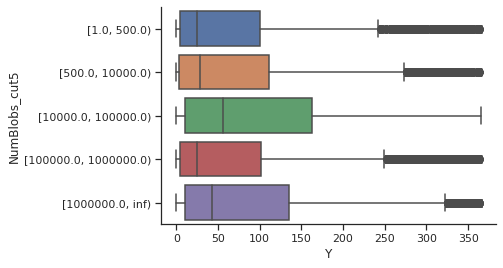

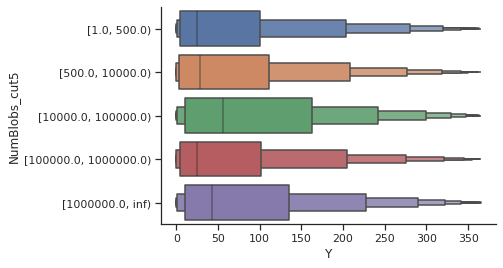

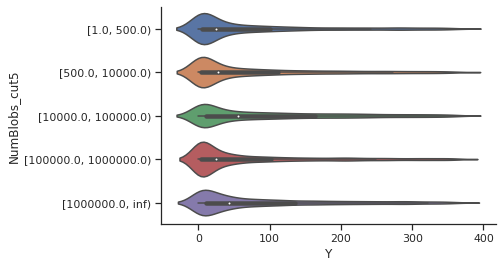

In [1225]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.boxenplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

values_list = dict_keys([0, 1, 2, 3, 4])


Saved survival function plot to 'NumBlobs_cut5.svg' and *.pdf


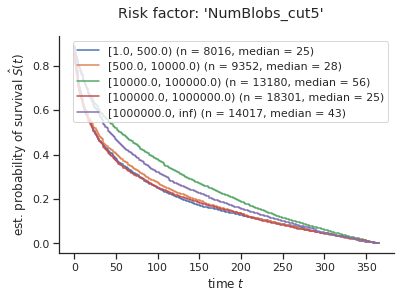

In [1226]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

---

/tmp/ipykernel_3850516/1061781849.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_cut] = cut_s


NumBlobs_cut3
[1.0, 10000.0)         17368
[10000.0, 200000.0)    20316
[200000.0, inf)        25182
dtype: int64

CategoricalDtype(categories=[[1.0, 10000.0), [10000.0, 200000.0), [200000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumBlobs_cut3', ylabel='CVE+project'>

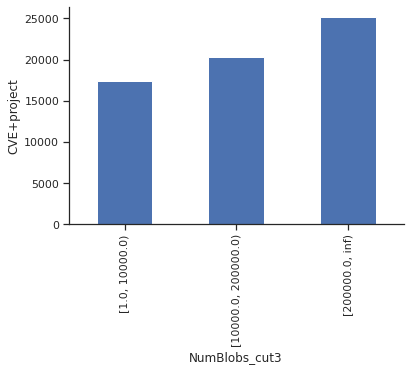

In [1227]:
column_cut = column_name + '_cut3'

cut_s = pd.cut(df[column_name].dropna(),
               bins=[1,1e4,2e5,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

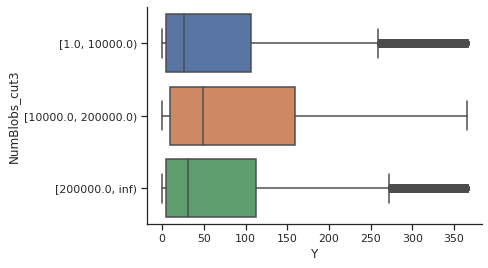

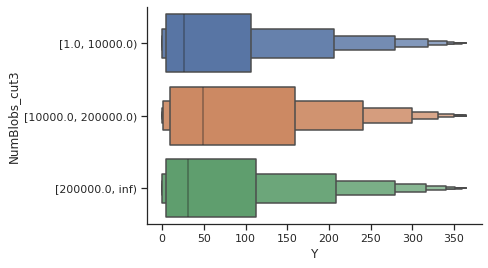

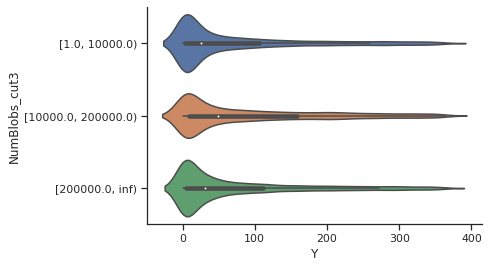

In [1228]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.boxenplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

In [1229]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 100,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

{0: Interval(1.0, 10000.0, closed='left'),
 1: Interval(10000.0, 200000.0, closed='left'),
 2: Interval(200000.0, inf, closed='left')}

all = 62866, selected = 62866, uncensored = 62866
Computing 100 × bootstrap Dxy for 62866 elements...
Computing confidence interval from 100 samples...


{
    "Cohort": 62866,
    "Number of patients": 62866.0,
    "% of cohort": 100.0,
    "Survival days, median": 34.0,
    "Survival years, median": 0.09315068493150686,
    "Dxy (full)": -0.00013721957814150088,
    "bootstrap": {
        "Dxy": -0.0003089398629415485,
        "Confidence interval low": -0.0008305729895388726,
        "Confidence interval high": 0.00021269326365577556,
        "confidence threshold %": 95.0,
        "bootstrap samples": 100
    }
}


Computing descriptive statistics like mean, median, etc....


count  median  min  25%    75%  max       mean  \
NumBlobs_cut3                                                         
[1.0, 10000.0)       17368    26.0    0  4.0  106.0  365  71.957220   
[10000.0, 200000.0)  20316    49.0    0  9.0  159.0  365  93.084318   
[200000.0, inf)      25182    31.0    0  5.0  112.0  365  74.192796   

                            std      skew  % of cohort  % of selected  \
NumBlobs_cut3                                                           
[1.0, 10000.0)        94.312677  1.469209    27.627016      27.627016   
[10000.0, 200000.0)  102.497759  1.037428    32.316355      32.316355   
[200000.0, inf)       93.978818  1.427602    40.056628      40.056628   

                     % of patients     IR  
NumBlobs_cut3                              
[1.0, 10000.0)           27.627016  102.0  
[10000.0, 200000.0)      32.316355  150.0  
[200000.0, inf)          40.056628  107.0

values_list = dict_keys([0, 1, 2])


Saved survival function plot to 'NumBlobs_cut3.svg' and *.pdf


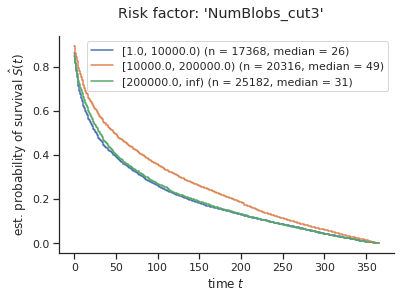

In [1230]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

In [1231]:
results_summary[column_cut] = {
    'cohort': ret['Cohort'],
    '% of cohort': ret['% of cohort'],
    'median': ret['Survival days, median'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval high'],
}

---
Scatterplots vs CVE lifetime

<AxesSubplot: xlabel='NumBlobs', ylabel='Y'>

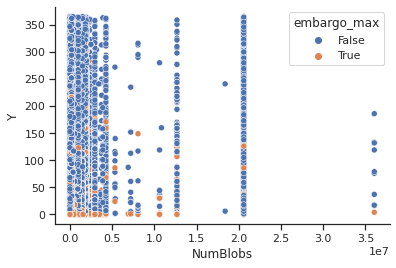

In [1232]:
sns.scatterplot(data=df, x=column_name, y='Y', hue='embargo_max')

[None]

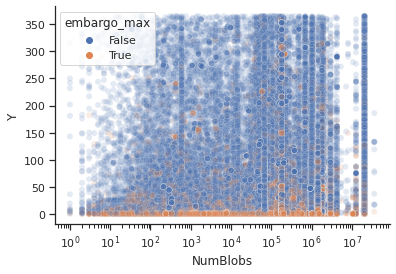

In [1233]:
splot = sns.scatterplot(data=df, x=column_name, y='Y', hue='embargo_max',alpha=0.15)
splot.set(xscale="log")

## Summary

In [1234]:
summary_df=pd.DataFrame.from_dict(results_summary, orient='index')
summary_df

cohort  % of cohort  median       Dxy   Dxy_low  \
NumCore_cut5                   62866    99.915694    34.0  0.123968  0.123511   
NumCore_cut2                   62866    99.915694    34.0  0.085865  0.085476   
NumCore_cut3                   62866    99.915694    34.0  0.087269  0.086755   
NumAuthors_cut5                62866    99.915694    34.0  0.089814  0.089299   
NumAuthors_cut3                62866    99.915694    34.0  0.104081  0.103561   
NumAuthors_cut2                62866    99.915694    34.0  0.095644  0.095214   
NumCore/NumAuthors cut3        62866    99.915694    34.0  0.052142  0.051787   
NumCommits_cut7                62866    99.829797    34.0  0.001194  0.000645   
NumCommits_cut3                62866    99.829797    34.0  0.014618  0.014172   
NumActiveMon [%] cut4          62866   100.000000    34.0 -0.088950 -0.089412   
NumActiveMon [%] cut3          62866   100.000000    34.0 -0.086115 -0.086611   
NumActiveMon [%] cut3b         62866   100.000000    34.0 -0.103758 -0.104218   
NumActiveMon_cut3              62866   100.000000    34.0 -0.077464 -0.077953   
NumActiveMon_cut3b             62866   100.000000    34.0 -0.038255 -0.038794   
CommitDateRange [days] cut6    62866   100.000000    34.0  0.016549  0.016055   
CommitDateRange [days] cut3b   62866   100.000000    34.0 -0.035377 -0.035890   
NumStars_cut4                  62866    75.789775    40.0  0.029064  0.028450   
NumStars_cut4+NumStars<10000   62866    64.567493    37.0  0.007449  0.006827   
NumStars_cut3                  62866    75.789775    40.0  0.035695  0.035069   
NumForks_cut5                  62866    99.988865    34.0  0.074354  0.073797   
NumForks_cut3                  62866    99.988865    34.0  0.070376  0.069915   
CommunitySize_cut5             62866    99.988865    34.0  0.062822  0.062272   
CommunitySize_cut3             62866    99.988865    34.0  0.058433  0.057903   
NumFiles_cut5                  62866   100.000000    34.0  0.057545  0.057037   
NumFiles_cut3                  62866   100.000000    34.0  0.053886  0.053380   
NumFiles_cut2.v1               62866   100.000000    34.0  0.031053  0.030552   
NumFiles_cut2.v2               62866   100.000000    34.0  0.038915  0.038530   
NumFiles_cut2                  62866   100.000000    34.0  0.050350  0.049971   
NumBlobs_cut5                  62866   100.000000    34.0  0.021260  0.020733   
NumBlobs_cut3                  62866   100.000000    34.0 -0.000309 -0.000831   

                              Dxy_high  
NumCore_cut5                  0.124425  
NumCore_cut2                  0.086255  
NumCore_cut3                  0.087782  
NumAuthors_cut5               0.090328  
NumAuthors_cut3               0.104601  
NumAuthors_cut2               0.096074  
NumCore/NumAuthors cut3       0.052498  
NumCommits_cut7               0.001743  
NumCommits_cut3               0.015063  
NumActiveMon [%] cut4        -0.088488  
NumActiveMon [%] cut3        -0.085619  
NumActiveMon [%] cut3b       -0.103299  
NumActiveMon_cut3            -0.076976  
NumActiveMon_cut3b           -0.037716  
CommitDateRange [days] cut6   0.017042  
CommitDateRange [days] cut3b -0.034863  
NumStars_cut4                 0.029677  
NumStars_cut4+NumStars<10000  0.008071  
NumStars_cut3                 0.036320  
NumForks_cut5                 0.074911  
NumForks_cut3                 0.070838  
CommunitySize_cut5            0.063371  
CommunitySize_cut3            0.058962  
NumFiles_cut5                 0.058054  
NumFiles_cut3                 0.054392  
NumFiles_cut2.v1              0.031554  
NumFiles_cut2.v2              0.039301  
NumFiles_cut2                 0.050728  
NumBlobs_cut5                 0.021786  
NumBlobs_cut3                 0.000213

In [1235]:
summary_df.sort_values(by='Dxy')

cohort  % of cohort  median       Dxy   Dxy_low  \
NumActiveMon [%] cut3b         62866   100.000000    34.0 -0.103758 -0.104218   
NumActiveMon [%] cut4          62866   100.000000    34.0 -0.088950 -0.089412   
NumActiveMon [%] cut3          62866   100.000000    34.0 -0.086115 -0.086611   
NumActiveMon_cut3              62866   100.000000    34.0 -0.077464 -0.077953   
NumActiveMon_cut3b             62866   100.000000    34.0 -0.038255 -0.038794   
CommitDateRange [days] cut3b   62866   100.000000    34.0 -0.035377 -0.035890   
NumBlobs_cut3                  62866   100.000000    34.0 -0.000309 -0.000831   
NumCommits_cut7                62866    99.829797    34.0  0.001194  0.000645   
NumStars_cut4+NumStars<10000   62866    64.567493    37.0  0.007449  0.006827   
NumCommits_cut3                62866    99.829797    34.0  0.014618  0.014172   
CommitDateRange [days] cut6    62866   100.000000    34.0  0.016549  0.016055   
NumBlobs_cut5                  62866   100.000000    34.0  0.021260  0.020733   
NumStars_cut4                  62866    75.789775    40.0  0.029064  0.028450   
NumFiles_cut2.v1               62866   100.000000    34.0  0.031053  0.030552   
NumStars_cut3                  62866    75.789775    40.0  0.035695  0.035069   
NumFiles_cut2.v2               62866   100.000000    34.0  0.038915  0.038530   
NumFiles_cut2                  62866   100.000000    34.0  0.050350  0.049971   
NumCore/NumAuthors cut3        62866    99.915694    34.0  0.052142  0.051787   
NumFiles_cut3                  62866   100.000000    34.0  0.053886  0.053380   
NumFiles_cut5                  62866   100.000000    34.0  0.057545  0.057037   
CommunitySize_cut3             62866    99.988865    34.0  0.058433  0.057903   
CommunitySize_cut5             62866    99.988865    34.0  0.062822  0.062272   
NumForks_cut3                  62866    99.988865    34.0  0.070376  0.069915   
NumForks_cut5                  62866    99.988865    34.0  0.074354  0.073797   
NumCore_cut2                   62866    99.915694    34.0  0.085865  0.085476   
NumCore_cut3                   62866    99.915694    34.0  0.087269  0.086755   
NumAuthors_cut5                62866    99.915694    34.0  0.089814  0.089299   
NumAuthors_cut2                62866    99.915694    34.0  0.095644  0.095214   
NumAuthors_cut3                62866    99.915694    34.0  0.104081  0.103561   
NumCore_cut5                   62866    99.915694    34.0  0.123968  0.123511   

                              Dxy_high  
NumActiveMon [%] cut3b       -0.103299  
NumActiveMon [%] cut4        -0.088488  
NumActiveMon [%] cut3        -0.085619  
NumActiveMon_cut3            -0.076976  
NumActiveMon_cut3b           -0.037716  
CommitDateRange [days] cut3b -0.034863  
NumBlobs_cut3                 0.000213  
NumCommits_cut7               0.001743  
NumStars_cut4+NumStars<10000  0.008071  
NumCommits_cut3               0.015063  
CommitDateRange [days] cut6   0.017042  
NumBlobs_cut5                 0.021786  
NumStars_cut4                 0.029677  
NumFiles_cut2.v1              0.031554  
NumStars_cut3                 0.036320  
NumFiles_cut2.v2              0.039301  
NumFiles_cut2                 0.050728  
NumCore/NumAuthors cut3       0.052498  
NumFiles_cut3                 0.054392  
NumFiles_cut5                 0.058054  
CommunitySize_cut3            0.058962  
CommunitySize_cut5            0.063371  
NumForks_cut3                 0.070838  
NumForks_cut5                 0.074911  
NumCore_cut2                  0.086255  
NumCore_cut3                  0.087782  
NumAuthors_cut5               0.090328  
NumAuthors_cut2               0.096074  
NumAuthors_cut3               0.104601  
NumCore_cut5                  0.124425

In [1236]:
summary_cut3_df=summary_df[
    summary_df.index.str.endswith('cut2') | 
    summary_df.index.str.endswith('cut3') | 
    summary_df.index.str.endswith('cut3b') | 
    summary_df.index.str.endswith('cut3b')
]
summary_cut3_df

cohort  % of cohort  median       Dxy   Dxy_low  \
NumCore_cut2                   62866    99.915694    34.0  0.085865  0.085476   
NumCore_cut3                   62866    99.915694    34.0  0.087269  0.086755   
NumAuthors_cut3                62866    99.915694    34.0  0.104081  0.103561   
NumAuthors_cut2                62866    99.915694    34.0  0.095644  0.095214   
NumCore/NumAuthors cut3        62866    99.915694    34.0  0.052142  0.051787   
NumCommits_cut3                62866    99.829797    34.0  0.014618  0.014172   
NumActiveMon [%] cut3          62866   100.000000    34.0 -0.086115 -0.086611   
NumActiveMon [%] cut3b         62866   100.000000    34.0 -0.103758 -0.104218   
NumActiveMon_cut3              62866   100.000000    34.0 -0.077464 -0.077953   
NumActiveMon_cut3b             62866   100.000000    34.0 -0.038255 -0.038794   
CommitDateRange [days] cut3b   62866   100.000000    34.0 -0.035377 -0.035890   
NumStars_cut3                  62866    75.789775    40.0  0.035695  0.035069   
NumForks_cut3                  62866    99.988865    34.0  0.070376  0.069915   
CommunitySize_cut3             62866    99.988865    34.0  0.058433  0.057903   
NumFiles_cut3                  62866   100.000000    34.0  0.053886  0.053380   
NumFiles_cut2                  62866   100.000000    34.0  0.050350  0.049971   
NumBlobs_cut3                  62866   100.000000    34.0 -0.000309 -0.000831   

                              Dxy_high  
NumCore_cut2                  0.086255  
NumCore_cut3                  0.087782  
NumAuthors_cut3               0.104601  
NumAuthors_cut2               0.096074  
NumCore/NumAuthors cut3       0.052498  
NumCommits_cut3               0.015063  
NumActiveMon [%] cut3        -0.085619  
NumActiveMon [%] cut3b       -0.103299  
NumActiveMon_cut3            -0.076976  
NumActiveMon_cut3b           -0.037716  
CommitDateRange [days] cut3b -0.034863  
NumStars_cut3                 0.036320  
NumForks_cut3                 0.070838  
CommunitySize_cut3            0.058962  
NumFiles_cut3                 0.054392  
NumFiles_cut2                 0.050728  
NumBlobs_cut3                 0.000213

<AxesSubplot: title={'center': 'Dxy'}>

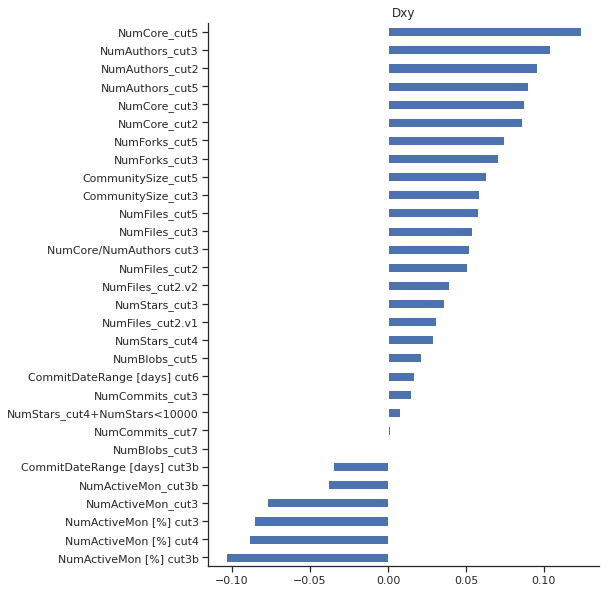

In [1237]:
summary_df['Dxy'].sort_values().plot(kind='barh',title='Dxy',figsize=(7, 10))

In [1245]:
summary_df['selected']=False
for column in ['NumAuthors_cut3', 'NumCore_cut3', 'NumFiles_cut3','NumActiveMon [%] cut3b']:
    summary_df.loc[column,'selected']=True

summary_df['name']=summary_df.index

summary_cut3_df=summary_df[
    summary_df.index.str.endswith('cut2') | 
    summary_df.index.str.endswith('cut3') | 
    summary_df.index.str.endswith('cut3b') | 
    summary_df.index.str.endswith('cut3b')
]
summary_cut3_df

cohort  % of cohort  median       Dxy   Dxy_low  \
NumCore_cut2                   62866    99.915694    34.0  0.085865  0.085476   
NumCore_cut3                   62866    99.915694    34.0  0.087269  0.086755   
NumAuthors_cut3                62866    99.915694    34.0  0.104081  0.103561   
NumAuthors_cut2                62866    99.915694    34.0  0.095644  0.095214   
NumCore/NumAuthors cut3        62866    99.915694    34.0  0.052142  0.051787   
NumCommits_cut3                62866    99.829797    34.0  0.014618  0.014172   
NumActiveMon [%] cut3          62866   100.000000    34.0 -0.086115 -0.086611   
NumActiveMon [%] cut3b         62866   100.000000    34.0 -0.103758 -0.104218   
NumActiveMon_cut3              62866   100.000000    34.0 -0.077464 -0.077953   
NumActiveMon_cut3b             62866   100.000000    34.0 -0.038255 -0.038794   
CommitDateRange [days] cut3b   62866   100.000000    34.0 -0.035377 -0.035890   
NumStars_cut3                  62866    75.789775    40.0  0.035695  0.035069   
NumForks_cut3                  62866    99.988865    34.0  0.070376  0.069915   
CommunitySize_cut3             62866    99.988865    34.0  0.058433  0.057903   
NumFiles_cut3                  62866   100.000000    34.0  0.053886  0.053380   
NumFiles_cut2                  62866   100.000000    34.0  0.050350  0.049971   
NumBlobs_cut3                  62866   100.000000    34.0 -0.000309 -0.000831   

                              Dxy_high  selected                          name  
NumCore_cut2                  0.086255     False                  NumCore_cut2  
NumCore_cut3                  0.087782      True                  NumCore_cut3  
NumAuthors_cut3               0.104601      True               NumAuthors_cut3  
NumAuthors_cut2               0.096074     False               NumAuthors_cut2  
NumCore/NumAuthors cut3       0.052498     False       NumCore/NumAuthors cut3  
NumCommits_cut3               0.015063     False               NumCommits_cut3  
NumActiveMon [%] cut3        -0.085619     False         NumActiveMon [%] cut3  
NumActiveMon [%] cut3b       -0.103299      True        NumActiveMon [%] cut3b  
NumActiveMon_cut3            -0.076976     False             NumActiveMon_cut3  
NumActiveMon_cut3b           -0.037716     False            NumActiveMon_cut3b  
CommitDateRange [days] cut3b -0.034863     False  CommitDateRange [days] cut3b  
NumStars_cut3                 0.036320     False                 NumStars_cut3  
NumForks_cut3                 0.070838     False                 NumForks_cut3  
CommunitySize_cut3            0.058962     False            CommunitySize_cut3  
NumFiles_cut3                 0.054392      True                 NumFiles_cut3  
NumFiles_cut2                 0.050728     False                 NumFiles_cut2  
NumBlobs_cut3                 0.000213     False                 NumBlobs_cut3

<AxesSubplot: title={'center': 'Dxy'}>

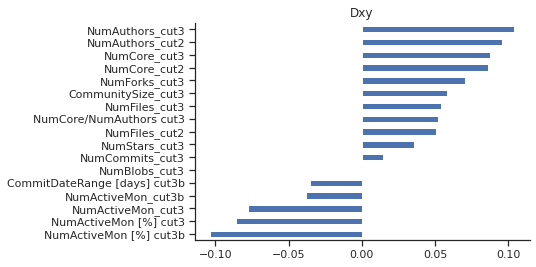

In [1239]:
summary_cut3_df.sort_values(by='Dxy').plot(y='Dxy',kind='barh',title='Dxy',legend=False)

<AxesSubplot: xlabel='Dxy', ylabel='name'>

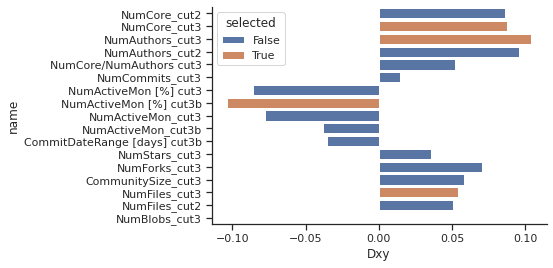

In [1246]:
sns.barplot(data=summary_cut3_df, x="Dxy",y='name',hue='selected',dodge=False)

<AxesSubplot: xlabel='Dxy', ylabel='name'>

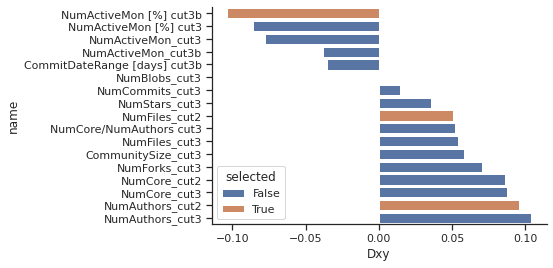

In [1241]:
sns.barplot(data=summary_cut3_df.sort_values(by='Dxy'), x="Dxy",y='name',hue='selected',dodge=False)

<AxesSubplot: xlabel='Dxy', ylabel='name'>

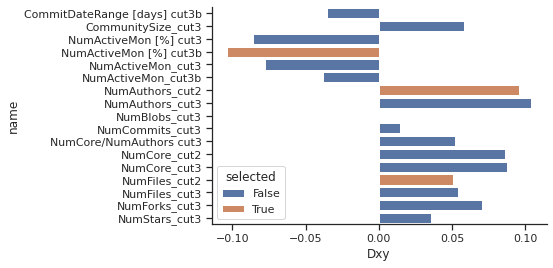

In [1242]:
sns.barplot(data=summary_cut3_df.sort_index(), x="Dxy",y='name',hue='selected',dodge=False)

<AxesSubplot: title={'center': 'Dxy'}>

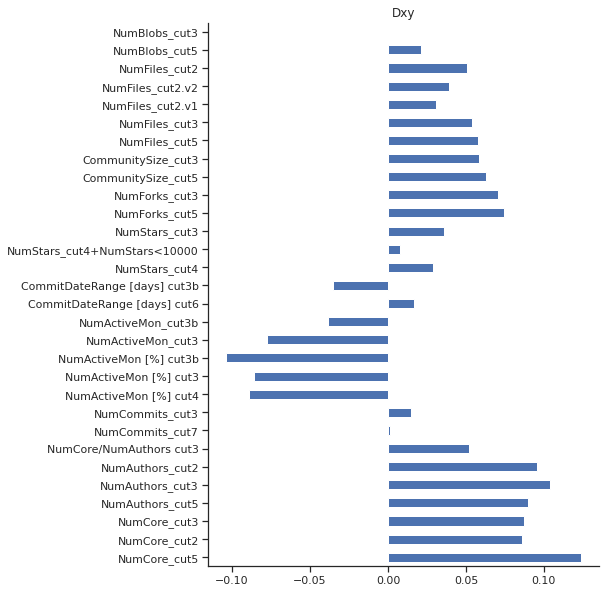

In [1243]:
summary_df['Dxy'].plot(kind='barh',title='Dxy',figsize=(7, 10))

<AxesSubplot: xlabel='Dxy', ylabel='name'>

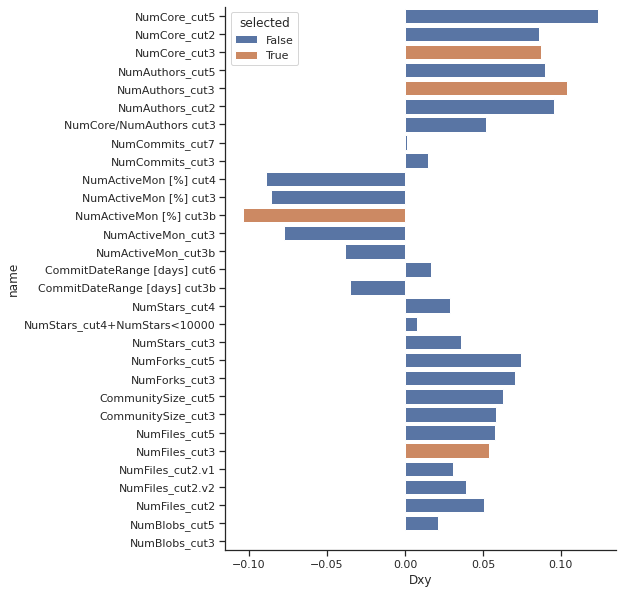

In [1250]:
fig, ax = plt.subplots(figsize=(7, 10))
sns.barplot(data=summary_df, x="Dxy",y='name',hue='selected',dodge=False,ax=ax)

In [1244]:
#ver='365days'
ver='most_used_language.365days'
summary_df.to_csv(f"survey_analysis_project_metadata.{ver}.csv")